# Forecasting Future PTAs 
## for Periodic Light Curves


The following notebook goes through the calculations needed to build future pulsar timing arrays. The various empirical distributions used for the sky positions, residual RMS values, cadences and timespans are bason on either the distributions from known millisecond pulsars or forecasted search numbers from Keane, et al, 2014.

|Name|RA |DEC |Freq(Hz) |Strain|
|:---:|:---:|:---:|:-------:|:----:|
|SDSS_J164452.71+430752.2 | 16 44 52.7 | +43 07 52.9 | 1.16E-08 | 4.88E-16|
|SDSS_J081617.73+293639.6 | 08 16 17.8 | +29 36 40.7 | 1.99E-08 | 4.37E-16|
|HS_1630+2355 |16 33 02.7 |+23 49 28.8 | 1.13E-08 | 3.95E-16|
|SDSS_J141244.09+421257.6 |12 14 44.7 | +27 14 16.7 | 5.34E-08 |5.89E-16|

In [1]:
import pickle, copy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
import matplotlib as mpl
import matplotlib.cm as cm
import scipy.stats as sps

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# import sys
# sys.path.insert(0,'/Users/hazboun/software_development/hasasia/')
import hasasia.sensitivity as hsen
import hasasia.sim as hsim
import hasasia.utils as utils
import hasasia.skymap as hsky
# from la_forge.utils import epoch_ave_resid

In [4]:
#healpy imports
import healpy as hp
import astropy.units as u
import astropy.constants as c
from astropy.coordinates import SkyCoord
import plot #Script originally written by Leo Stein for making pretty sky maps. 

In [5]:
def sky_ave_detect(sm,tspan,snr=3):
    return snr*np.sqrt(np.mean(sm.S_eff,axis=1)/tspan)

In [6]:
def sky_detect(sm,tspan,snr=3):
    return snr*np.sqrt(sm.S_eff/tspan)

In [7]:
def tspan_filter(psrs,tspan_min=3):
    return [p for p in psrs if hsen.get_Tspan([p])>=tspan_min]

In [8]:
fyr = 1/(365.25*24*3600)
freqs = np.logspace(np.log10(3e-10),np.log10(2e-7),300)
freqs = np.sort(np.append(freqs,[1.13e-8])) #Append the frequency of candidate HS1630

### Make the NANOGrav Sensitivity Curve

In [20]:
ng11yr_psrs=np.loadtxt('ng11yr_psrs.txt',
                       dtype=[('psr', 'U32'), ('telescope', 'U32'),('full',float),
                              ('wn',float),('A_rn',float),('gamma',float),
                              ('theta',float),('phi',float),('cadence',float),('tspan',float)],
                       delimiter=',',
                       skiprows=1)

In [10]:
rn_psrs = {'B1855+09':[10**-13.7707, 3.6081],
           'B1937+21':[10**-13.2393, 2.46521],
           'J0030+0451':[10**-14.0649, 4.15366],
           'J0613-0200':[10**-13.1403, 1.24571],
           'J1012+5307':[10**-12.6833, 0.975424],
           'J1643-1224':[10**-12.245, 1.32361],
           'J1713+0747':[10**-14.3746, 3.06793],
           'J1747-4036':[10**-12.2165, 1.40842],
           'J1903+0327':[10**-12.2461, 2.16108],
           'J1909-3744':[10**-13.9429, 2.38219],
           'J2145-0750':[10**-12.6893, 1.32307],
           }

In [13]:
psrnames = ng11yr_psrs['psr']
timespans = ng11yr_psrs['tspan']
cad = ng11yr_psrs['cadence']
phi = ng11yr_psrs['phi']
theta = ng11yr_psrs['theta']
sigmas = np.array([rms*1e-6 if not np.isnan(rms) else ng11yr_psrs['full'][ii]*1e-6
                   for ii,rms in enumerate(ng11yr_psrs['wn'])])
# A=[rn_psrs[p][0] if p in rn_psrs.keys() else 0 for p in psrnames]
# alphas=3-np.array([rn_psrs[p][1] if p in rn_psrs.keys() else 0 for p in psrnames])
# alphas /= 2

In [14]:
cad

array([10.7426, 28.0962, 10.4357, 11.4141, 11.0682, 26.0893, 21.4853,
       22.8281, 20.2917, 24.35  , 18.2625, 24.35  , 22.8281, 11.7823,
       20.2917, 40.5833,  8.6964, 10.1458, 19.2237, 26.0893, 12.175 ,
        9.8716, 28.0962,  9.6118, 20.2917, 10.7426, 12.5948, 24.35  ,
       14.0481, 20.2917, 17.3929, 13.0446, 26.0893, 13.0446])

In [15]:
sigmas

array([4.82e-07, 1.10e-07, 3.94e-07, 3.08e-07, 2.41e-07, 4.54e-07,
       1.99e-07, 1.80e-07, 3.54e-07, 3.24e-07, 5.71e-07, 1.81e-07,
       1.83e-07, 3.82e-07, 7.57e-07, 1.03e-07, 3.64e-07, 1.02e-07,
       4.03e-07, 1.58e-06, 2.05e-07, 5.73e-07, 7.00e-08, 5.15e-07,
       2.97e-07, 2.29e-07, 3.33e-07, 2.60e-07, 9.10e-08, 1.19e-07,
       3.04e-07, 1.33e-06, 8.36e-07, 2.87e-07])

In [16]:
psrs_sim_ng11 = hsim.sim_pta(timespan=timespans,cad=cad,
                             sigma=sigmas,#A_rn=A,alpha=alphas,,freqs=freqs
                             phi=phi,theta=theta,uneven=True)
specs_ng11 = []
for p in psrs_sim_ng11:
    sp = hsen.Spectrum(p, freqs=freqs)
    _ = sp.NcalInv
    specs_ng11.append(sp)
#     print('\rPSR {0} complete'.format(p.name),end='',flush=True)

In [11]:
NSIDE = 8
NPIX = hp.nside2npix(NSIDE)
IPIX = np.arange(NPIX)
theta_gw, phi_gw = hp.pix2ang(nside=NSIDE,ipix=IPIX)

In [12]:
with open('ng11yr_sky_sensitivity_wn.has','rb') as fin:
    SM_ng11 = pickle.load(fin)

In [13]:
# SM_ng11 = hsky.SkySensitivity(specs_ng11,theta_gw, phi_gw)

# tspan_ng11 = SM_ng11.Tspan#hsen.get_Tspan(psrs_sim_ng11)

In [14]:
SkySNR_ng11 = SM_ng11.SNR(3.95e-16)

In [15]:
fidx = list(SM_ng11.freqs).index(1.13e-8)
fidx

167

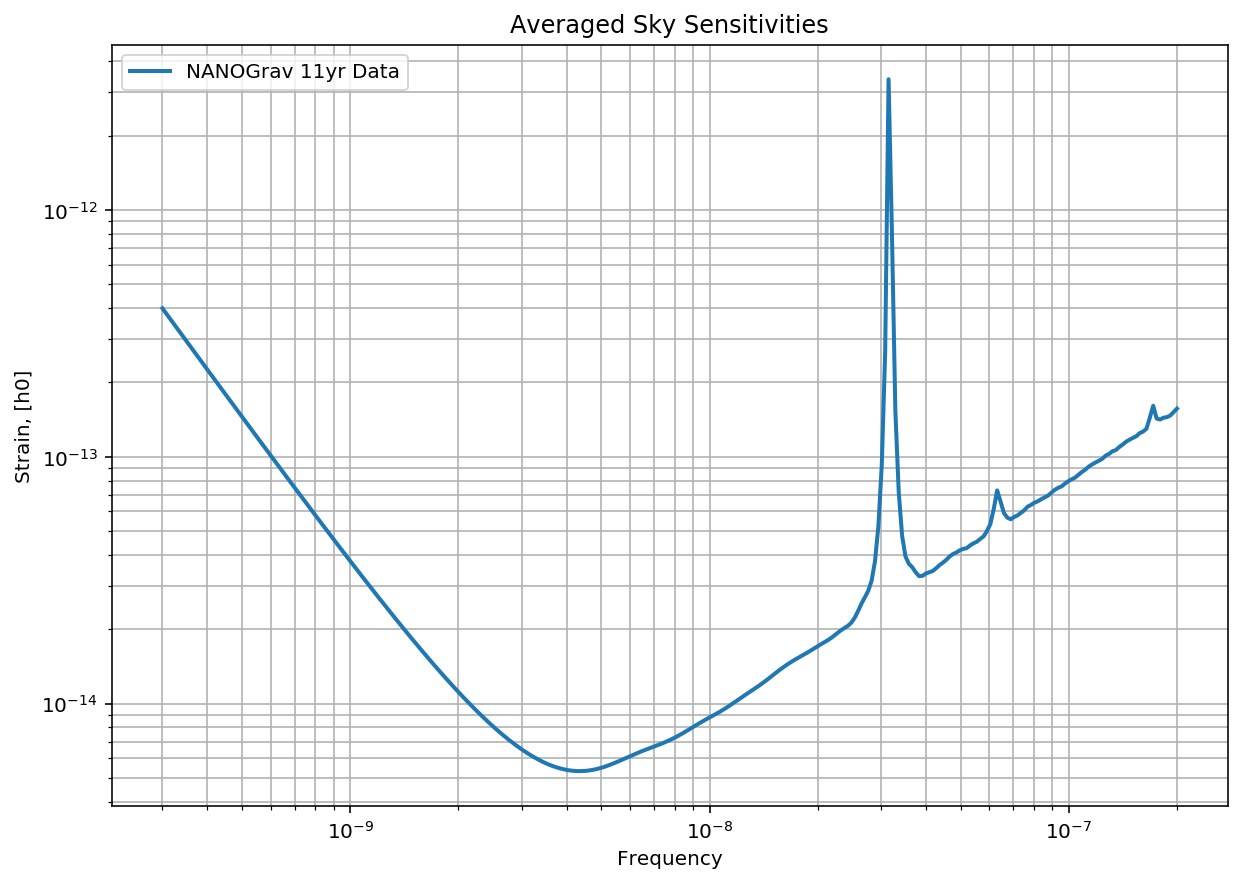

In [17]:
plt.figure(figsize=[10,7])

plt.loglog(SM_ng11.freqs,sky_ave_detect(SM_ng11,SM_ng11.Tspan,3),
           label='NANOGrav 11yr Data',lw=2)
plt.legend(loc='upper left')
plt.xlabel('Frequency')
plt.ylabel('Strain, [h0]')
plt.title('Averaged Sky Sensitivities')
plt.grid(which='both')
plt.show()

## IPTA 2025
Here we start with DR2 (Perera, et al. 2019) and add 4 pulsars per year with with RMS residual values pulled from a Gaussian distribution centered at 300 nanoseconds with a 100 ns standard deviation. The sky positions are pulled from a 2d distribution made from the current sky positions. 
* Residual RMS: `Normal(300ns,100ns)`
* Add 4 pulsars per year starting in 2015
* Sky position uses a `scipy.stats` rvs using current sky positions.   

In [18]:
ipta_dr2_noise=np.genfromtxt('./ipta_dr2_rms.txt', delimiter='\t', skip_header=1,
                                   dtype='U20, f4, f4, f4, f4',
                                   names=['psr','theta', 'phi','wn','tspan'])

In [21]:
cad_hist = np.histogram(2*ng11yr_psrs['cadence'], bins=20, density=True)
cad_rv = sps.rv_histogram(cad_hist)
cad_ipta = cad_rv.rvs(size=63)
cad_ipta

array([43.32577214, 46.91213217, 47.01524069, 48.56003444, 26.93525609,
       23.75003243, 36.49886327, 50.74622023, 46.44602846, 41.37677287,
       23.37844066, 58.41298281, 40.13665962, 22.79211239, 48.75591076,
       35.94186713, 48.5743929 , 24.64406015, 56.09576945, 39.96422243,
       25.58669207, 23.06118842, 17.66271505, 19.41133896, 22.08622107,
       52.03090839, 46.42455643, 80.83572577, 48.79056371, 22.16364788,
       21.24384079, 25.72634233, 22.68326632, 24.33406404, 25.47951046,
       42.05103142, 41.10474467, 19.76350849, 20.29229571, 79.38983709,
       44.04509545, 41.29028366, 23.7433889 , 25.17215931, 20.76994347,
       24.1180862 , 20.42157316, 21.66675782, 20.42367811, 23.78749325,
       22.43457483, 22.58961116, 22.62257132, 19.34494486, 21.34110399,
       42.43003289, 39.15542059, 21.3595185 , 25.11205231, 41.20621961,
       18.34376103, 27.53094726, 17.44114782])

In [22]:
tspans_ipta = ipta_dr2_noise['tspan']
cad_ipta = cad_ipta
phi_ipta = ipta_dr2_noise['phi']
theta_ipta = ipta_dr2_noise['theta']
sigmas_ipta = ipta_dr2_noise['wn']*1e-6

In [24]:
psrs_sim_dr2 = hsim.sim_pta(timespan=tspans_ipta,cad=cad_ipta,
                             sigma=sigmas_ipta,#A_rn=A,alpha=alphas,,freqs=freqs
                             phi=phi_ipta,theta=theta_ipta,uneven=True)

In [25]:
# with open('my_ipta_dr2_has_psrs.pkl','wb') as fout:
#     pickle.dump(psrs_sim_dr2,fout)

In [26]:
specs_dr2 = []
for p in tspan_filter(psrs_sim_dr2):
    sp = hsen.Spectrum(p, freqs=freqs)
    _ = sp.NcalInv
    specs_dr2.append(sp)
#     print('\rPSR {0} complete'.format(p.name),end='',flush=True)

In [27]:
SM_dr2 = hsky.SkySensitivity(specs_dr2,theta_gw, phi_gw)

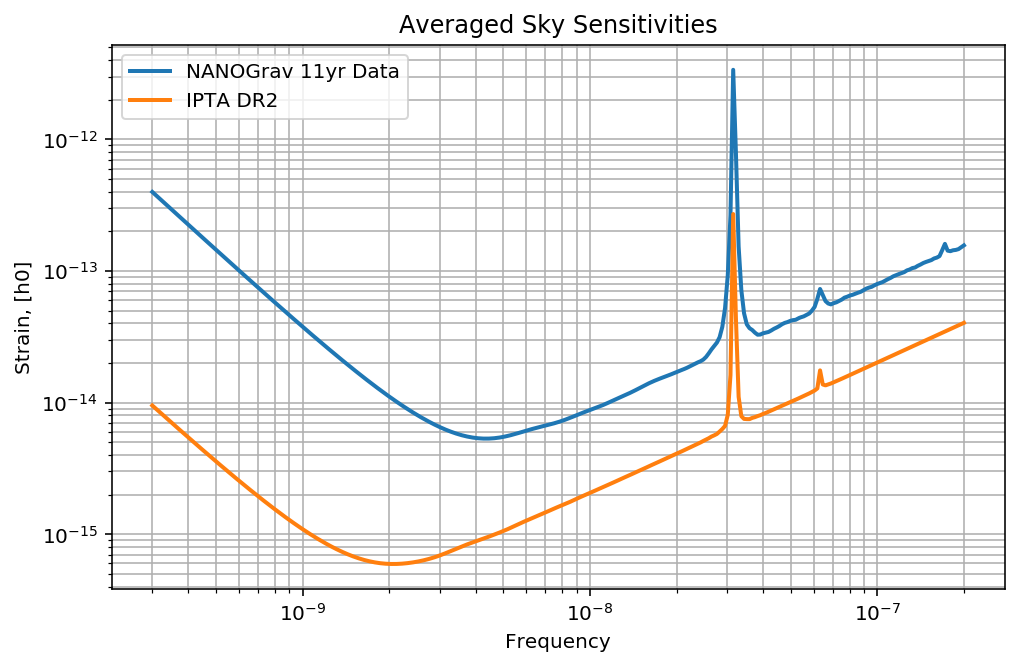

In [29]:
plt.figure(figsize=[8,5])

plt.loglog(SM_ng11.freqs,sky_ave_detect(SM_ng11,SM_ng11.Tspan,3),
           label='NANOGrav 11yr Data',lw=2)
plt.loglog(SM_dr2.freqs,sky_ave_detect(SM_dr2,SM_dr2.Tspan,3),
           label='IPTA DR2',lw=2)
plt.legend(loc='upper left')
plt.xlabel('Frequency')
plt.ylabel('Strain, [h0]')
plt.title('Averaged Sky Sensitivities')
plt.grid(which='both')
plt.show()

In [37]:
phi_hist = np.histogram(phi_ipta, bins=10, density=True)
phi_rv = sps.rv_histogram(phi_hist)
theta_hist = np.histogram(theta_ipta, bins=10, density=True)
theta_rv = sps.rv_histogram(theta_hist)

In [38]:
theta_ipta_new = theta_rv.rvs(size=40)
phi_ipta_new = phi_rv.rvs(size=40)

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


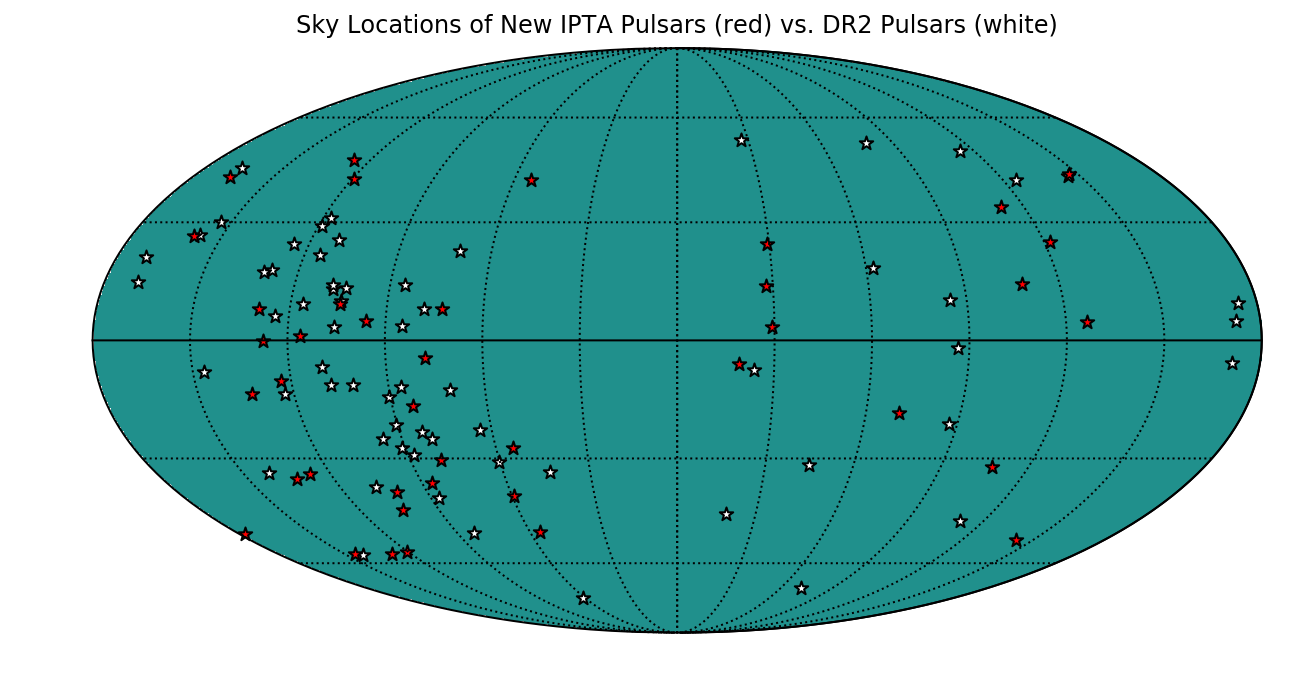

In [39]:
hp.mollview(np.ones_like(SM_dr2.S_effSky[0,:]),rot=(180,0,0),#np.log10(1/SM.Sn[idx]),"SNR with Single Source"
            cmap='viridis',cbar=None,title='')
hp.visufunc.projscatter(theta_ipta,phi_ipta,marker='*',
                        color='white',edgecolors='k',s=50)
hp.visufunc.projscatter(theta_ipta_new,phi_ipta_new,
                        marker='*',
                        color='red',edgecolors='k',s=50)
hp.graticule()
fig = plt.gcf()
ax = plt.gca()
plt.title('Sky Locations of New IPTA Pulsars (red) vs. DR2 Pulsars (white)')
plt.show()
plt.close()

In [40]:
new_tspans = np.repeat(np.arange(1,11),4)

In [43]:
#Add 4 pulsars per year
tspans_ipta_plus = np.append(ipta_dr2_noise['tspan']+10,new_tspans[::-1])
#Keep the average cadence of the DR2 pulsars
cad_ipta_plus = np.append(cad_ipta,23*np.ones_like(phi_ipta_new))
# Add to DR2 sky locations from scipy histograms above
phi_ipta_plus = np.append(ipta_dr2_noise['phi'],phi_ipta_new)
theta_ipta_plus = np.append(ipta_dr2_noise['theta'],theta_ipta_new)

#Use a truncated Gaussian distribution to pull residual RMS values.
lower, upper = 10e-9, 600e-9
mu, sigma = 300e-9, 100e-9 #Mean = 300ns, StDev = 100ns
rms_ipta_plus = sps.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
new_rms = rms_ipta_plus.rvs(40)
sigmas_ipta_plus = np.append(ipta_dr2_noise['wn']*1e-6, new_rms)
len(tspans_ipta_plus),len(phi_ipta_plus),len(theta_ipta_plus),len(sigmas_ipta_plus)
# plt.hist(new_rms,histtype='step',bins=15)
# plt.show()

(103, 103, 103, 103)

In [45]:
# Assume high cadence campaigns across the IPTA observations for pulsars with < 300ns precision.
for ii,rms in enumerate(sigmas_ipta_plus):
    if rms <300e-9:
        cad_ipta_plus[ii]=56

In [46]:
psrs_ipta_plus = hsim.sim_pta(timespan=tspans_ipta_plus,
                              cad=cad_ipta_plus,
                              sigma=sigmas_ipta_plus,#A_rn=A,alpha=alphas,freqs=freqs, #One could add in red noise if desired
                              phi=phi_ipta_plus,
                              theta=theta_ipta_plus,uneven=True)

In [30]:
# with open('my_ipta_plus_has_psrs.pkl','wb') as fout:
#     pickle.dump(psrs_ipta_plus,fout)

In [47]:
specs_ipta_plus = []
for p in tspan_filter(psrs_ipta_plus):
    sp = hsen.Spectrum(p, freqs=freqs)
    _ = sp.NcalInv
    specs_ipta_plus.append(sp)

In [48]:
SM_ipta_plus = hsky.SkySensitivity(specs_ipta_plus,theta_gw, phi_gw)

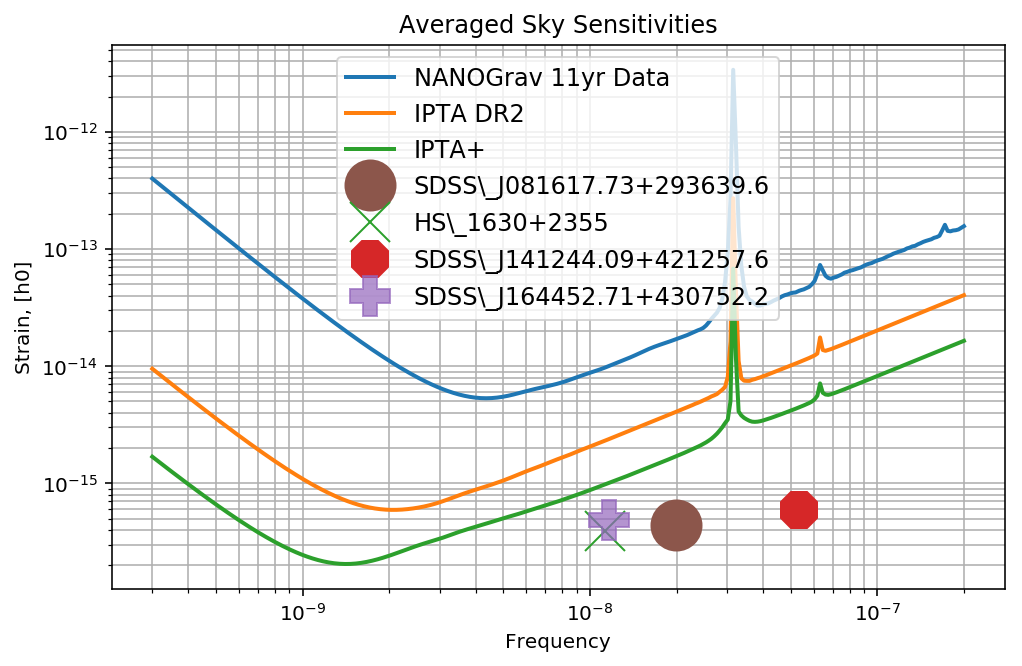

In [50]:
snr=3
plt.figure(figsize=[8,5])

plt.loglog(SM_ng11.freqs,sky_ave_detect(SM_ng11,SM_ng11.Tspan,snr),
           label='NANOGrav 11yr Data',lw=2)
plt.loglog(SM_dr2.freqs,sky_ave_detect(SM_dr2,SM_dr2.Tspan,snr),
           label='IPTA DR2',lw=2)
plt.loglog(SM_ipta_plus.freqs,sky_ave_detect(SM_ipta_plus,SM_ipta_plus.Tspan,snr),
           label='IPTA+',lw=2)
plt.plot(1.99e-08, 4.37e-16,'.',markersize=50,color='C5',label='SDSS\_J081617.73+293639.6')
plt.plot(1.13e-08, 3.95e-16,'x',markersize=20,color='C2',label='HS\_1630+2355')
plt.plot(5.34e-08, 5.89e-16,'8',markersize=20,color='C3',label='SDSS\_J141244.09+421257.6')
plt.plot(1.16e-08, 4.88e-16,'P',markersize=20,linewidth=3,alpha=0.7,color='C4',label='SDSS\_J164452.71+430752.2')
plt.legend(loc='upper center',fontsize=12)
plt.xlabel('Frequency')
plt.ylabel('Strain, [h0]')
plt.title('Averaged Sky Sensitivities')
plt.grid(which='both')
plt.show()

In [53]:
f0=1.13e-8
hcw = hsky.h_circ(2.174e8, 120,f0,SM_ipta_plus.Tspan,SM_ipta_plus.freqs).to('').value
h0 = hsky.h0_circ(2.174e8, 120, 1.13e-8).to('').value
SkySNR_ipta_plus = SM_ipta_plus.SNR(h0)

In [54]:
cand1 = SkyCoord(ra='16h44m52.7s',dec='+43d07m52.9s')
cand2 = SkyCoord(ra='11h48m57.4s',dec='+16d00m22.7s')
cand3 = SkyCoord(ra='16h33m02.7s',dec='+23d49m28.8s')

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


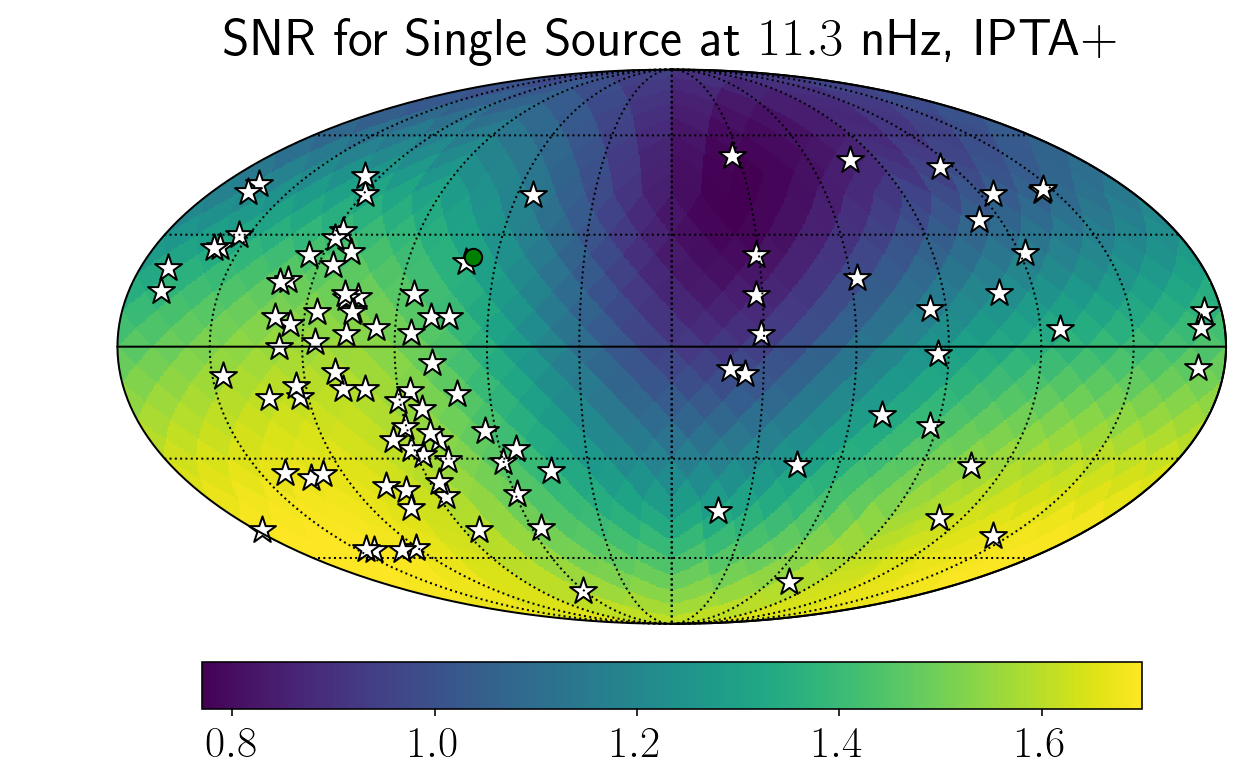

In [56]:
plt.rc('text', usetex=True)
hp.mollview(SkySNR_ipta_plus[fidx,:],rot=(180,0,0),#np.log10(1/SM.Sn[idx]),"SNR with Single Source"
            cmap='viridis',cbar=None,title='')#,min=0.9,max=13.0)
hp.visufunc.projscatter(SM_ipta_plus.thetas,SM_ipta_plus.phis,marker='*',
                        color='white',edgecolors='k',s=200)
hp.visufunc.projscatter(np.pi/2-cand3.dec.to('rad').value,cand3.ra.to('rad').value,marker='.',
                        color='green',edgecolors='black',s=300)

hp.graticule()
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cmap = fig.colorbar(image, ax=ax, orientation='horizontal',shrink=0.8,pad=0.05)

plt.rcParams.update({'font.size':22,'text.usetex':True})
ax.set_title("SNR for Single Source at $11.3$ nHz, IPTA+")
plt.show()

In [57]:
sky_idx=hp.ang2pix(NSIDE,np.pi/2-cand3.dec.to('rad').value,cand3.ra.to('rad').value)
snr_cand3=SkySNR_ipta_plus[sky_idx]

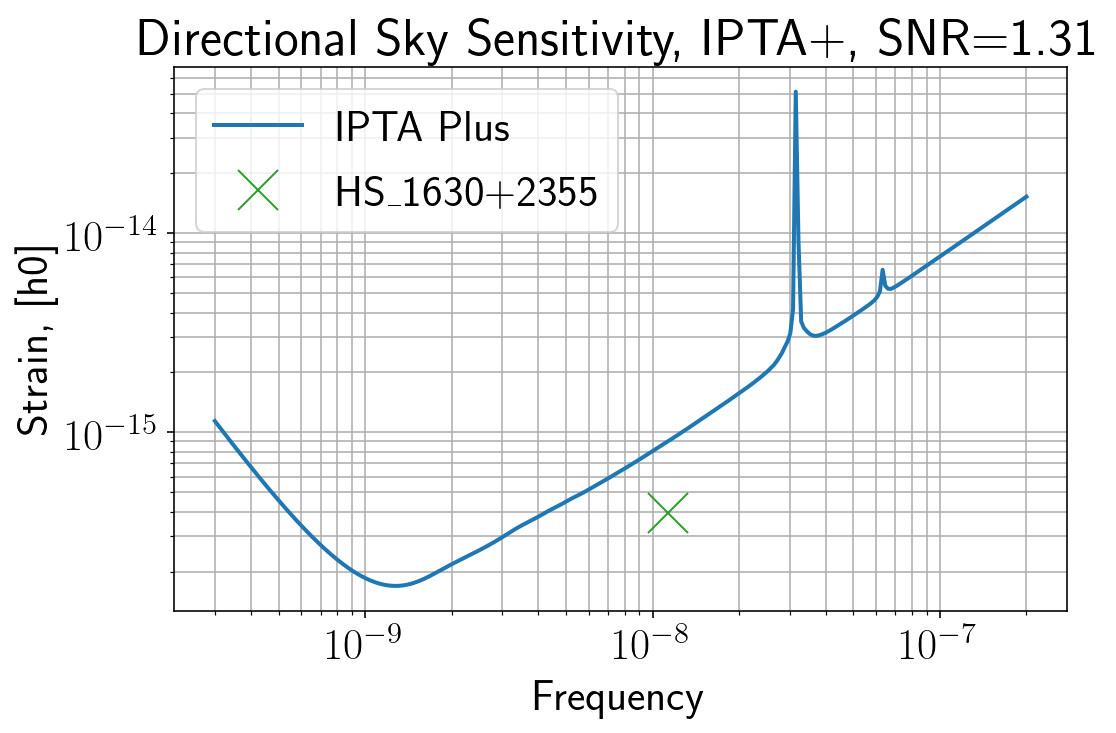

In [61]:
snr=3
plt.figure(figsize=[8,5])

plt.loglog(SM_ipta_plus.freqs,SM_ipta_plus.h_thresh(snr)[:,sky_idx],
           label='IPTA Plus',lw=2)
plt.plot(1.13e-08,3.95e-16,'x',markersize=20,color='C2',label='HS\_1630+2355')
plt.legend(loc='upper left')
plt.xlabel('Frequency')
plt.ylabel('Strain, [h0]')
plt.title('Directional Sky Sensitivity, IPTA+, SNR={0:1.2f}'.format(SkySNR_ipta_plus[fidx,sky_idx]))
plt.grid(which='both')
plt.show()

In [70]:
# np.savetxt('ipta_plus_best_sky_detect_snr3.txt',
#            np.array((SM_ipta_plus.freqs,snr*np.sqrt(SM_ipta_plus.S_eff[:,sky_idx]/tspan_ipta_plus))).T,
#            fmt='%.18e %.18e',header='freq[Hz] gw_strain')

### Making SKA1 PTA

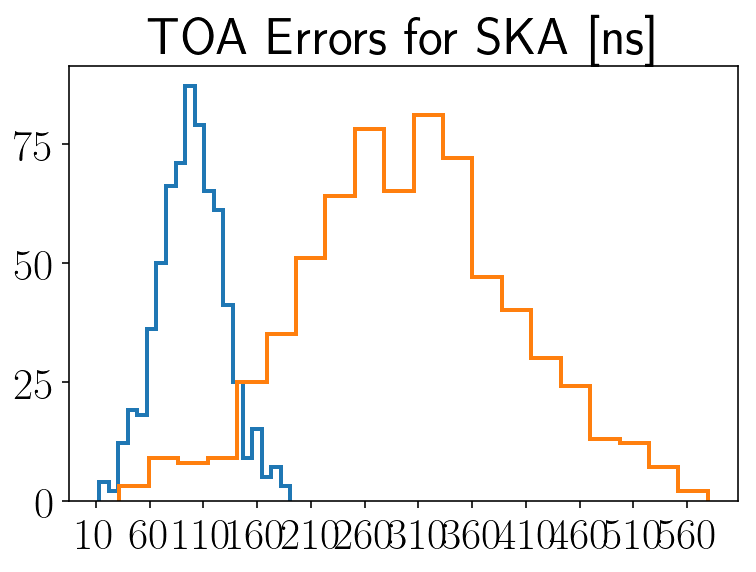

In [85]:
fraction = 0.15
Np_low = int(1500*fraction)
Np_mid = int(3000*fraction)
lower1, upper1 = 9e-9, 201e-9
mu1, sigma1 = 100e-9, 30e-9
RVSopt = sps.truncnorm((lower1 - mu1) / sigma1, (upper1 - mu1) / sigma1, loc=mu1, scale=sigma1)

lower2, upper2 = 9e-9, 601e-9
mu2, sigma2 = 300e-9, 100e-9
RVScons = sps.truncnorm((lower2 - mu2) / sigma2, (upper2 - mu2) / sigma2, loc=mu2, scale=sigma2)

errors_opt = RVSopt.rvs(Np_low+Np_mid)
errors_cons = RVScons.rvs(Np_low+Np_mid)

plt.hist(errors_opt/1e-9,bins=20,histtype='step',label='Optimistic',lw=2)
plt.hist(errors_cons/1e-9,bins=20,histtype='step',label='Pessimistic',lw=2)
plt.xticks(np.arange(10,610,50))
plt.title('TOA Errors for SKA [ns]')
plt.show()
plt.close()

l_low = np.random.uniform(0,2*np.pi,size=Np_low)
sinb_low_a = np.random.uniform(np.sin(np.deg2rad(-90)),np.sin(np.deg2rad(-5)),size=Np_low//2)
sinb_low_b = np.random.uniform(np.sin(np.deg2rad(5)),np.sin(np.deg2rad(90)),size=Np_low//2 + Np_low%2)
sinb_low = np.append(sinb_low_a, sinb_low_b)
b_low = np.arcsin(sinb_low)
sky_pos_low = SkyCoord(l=l_low*u.rad, b=b_low*u.rad, frame='galactic')
phis_low = sky_pos_low.icrs.ra.to('rad').value
thetas_low = np.pi/2-sky_pos_low.icrs.dec.to('rad').value

l_mid = np.random.uniform(0,2*np.pi,size=Np_mid)
sinb_mid = np.random.uniform(np.sin(np.deg2rad(-10)),np.sin(np.deg2rad(10)),size=Np_mid)
b_mid = np.arcsin(sinb_mid)
sky_pos_mid = SkyCoord(l=l_mid*u.rad, b=b_mid*u.rad, frame='galactic')
phis_mid = sky_pos_mid.icrs.ra.to('rad').value
thetas_mid = np.pi/2-sky_pos_mid.icrs.dec.to('rad').value
new_phis_ska1 = np.append(phis_low,phis_mid)
new_thetas_ska1 = np.append(thetas_low,thetas_mid)


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


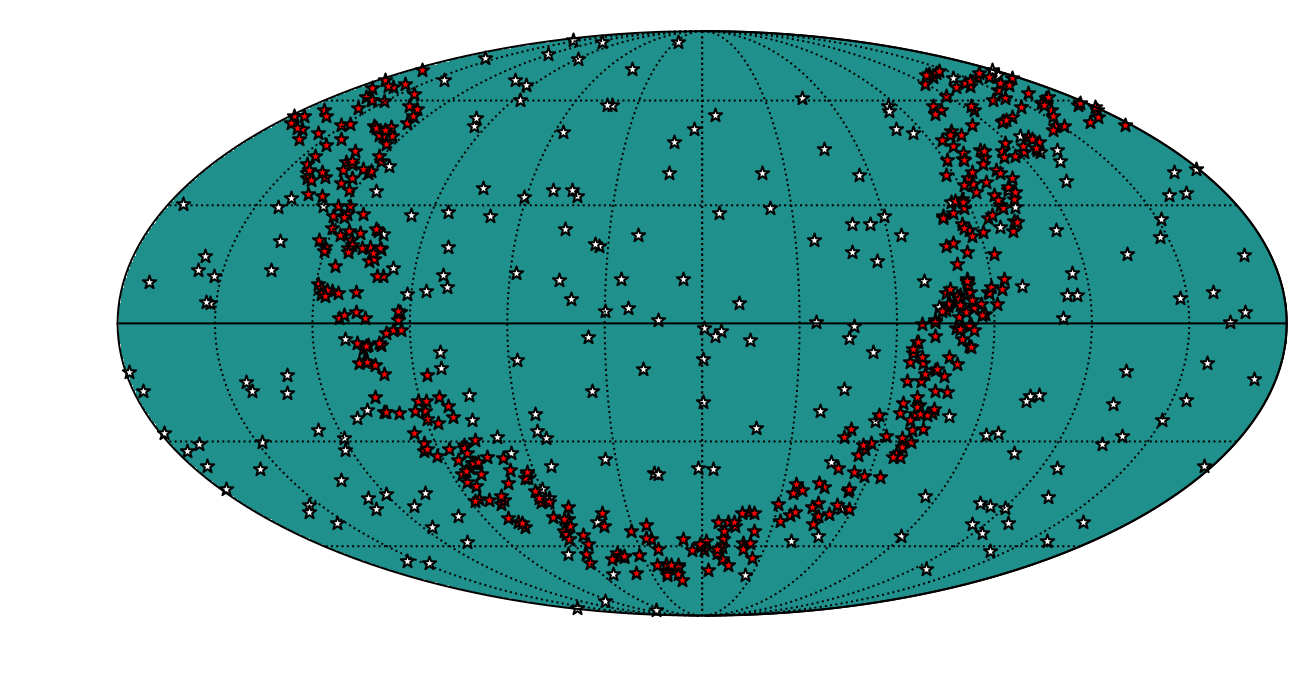

In [51]:
hp.mollview(np.ones_like(SM_ipta_plus.S_effSky[0,:]),rot=(180,0,0),#np.log10(1/SM.Sn[idx]),"SNR with Single Source"
            cmap='viridis',cbar=None,title='')
hp.visufunc.projscatter(thetas_low,phis_low,marker='*',
                        color='white',edgecolors='k',s=50)
hp.visufunc.projscatter(thetas_mid,phis_mid,marker='*',
                        color='red',edgecolors='k',s=50)
hp.graticule()
fig = plt.gcf()
ax = plt.gca()
plt.show()
plt.close()

In [54]:
#Add 4 pulsars per year
tspans_ska1 = np.append(tspans_ipta_plus+5,np.random.uniform(low=1,high=4,size=Np_low+Np_mid))
#Keep the average cadence of the NG11yr pulsars
cad_ska1 = np.append(cad_ipta_plus,56*np.ones(Np_low+Np_mid))
# Add to DR2 sky locations from scipy histograms above
phis_ska1 = np.append(phi_ipta_plus,new_phis_ska1)
thetas_ska1 = np.append(theta_ipta_plus,new_thetas_ska1)


sigma_ska1o = np.append(sigmas_ipta_plus,errors_opt)
sigma_ska1c = np.append(sigmas_ipta_plus,errors_cons)

ska1_opt = hsim.sim_pta(timespan=tspans_ska1,cad=cad_ska1,
                        sigma=sigma_ska1o,phi=phis_ska1,theta=thetas_ska1,A_rn=1.42e-15,alpha=-2/3.,freqs=freqs)
ska1_cons = hsim.sim_pta(timespan=tspans_ska1,cad=cad_ska1,
                         sigma=sigma_ska1c,phi=phis_ska1,theta=thetas_ska1,A_rn=1.42e-15,alpha=-2/3.,freqs=freqs)

In [42]:
# with open('ska1_cons_has_psrs_wGWB_ng11yr.pkl','wb') as fout:
#     pickle.dump(ska1_cons,fout)
# with open('ska1_opt_has_psrs_wGWB_ng11yr.pkl','wb') as fout:
#     pickle.dump(ska1_opt,fout)
with open('ska1_cons_has_psrs.pkl','rb') as fin:
    ska1_cons = pickle.load(fin)
with open('ska1_opt_has_psrs.pkl','rb') as fin:
    ska1_opt = pickle.load(fin)

In [77]:
# with open('ska1_opt_has_psrs_wGWB_ng11yr.pkl','rb') as fout:
#     ska1_opt=pickle.load(fout)

In [43]:
len(ska1_opt)

778

In [44]:
spec_ska1_opt = []
for p in tspan_filter(ska1_opt):
    sp = hsen.Spectrum(p, freqs=freqs)
    _ = sp.NcalInv
    spec_ska1_opt.append(sp)

In [45]:
spec_ska1_cons = []
for p in tspan_filter(ska1_cons):
    sp = hsen.Spectrum(p, freqs=freqs)
    _ = sp.NcalInv
    spec_ska1_cons.append(sp)

In [46]:
SM_ska1_opt = hsky.SkySensitivity(spec_ska1_opt, theta_gw, phi_gw)#, pulsar_term=True)
SM_ska1_cons = hsky.SkySensitivity(spec_ska1_cons,theta_gw, phi_gw)
tspan_ska1_opt = SM_ska1_opt.Tspan
tspan_ska1_cons = SM_ska1_cons.Tspan

In [48]:
tspan_ska1_opt/(365.25*24*3600)

44.400001525878906

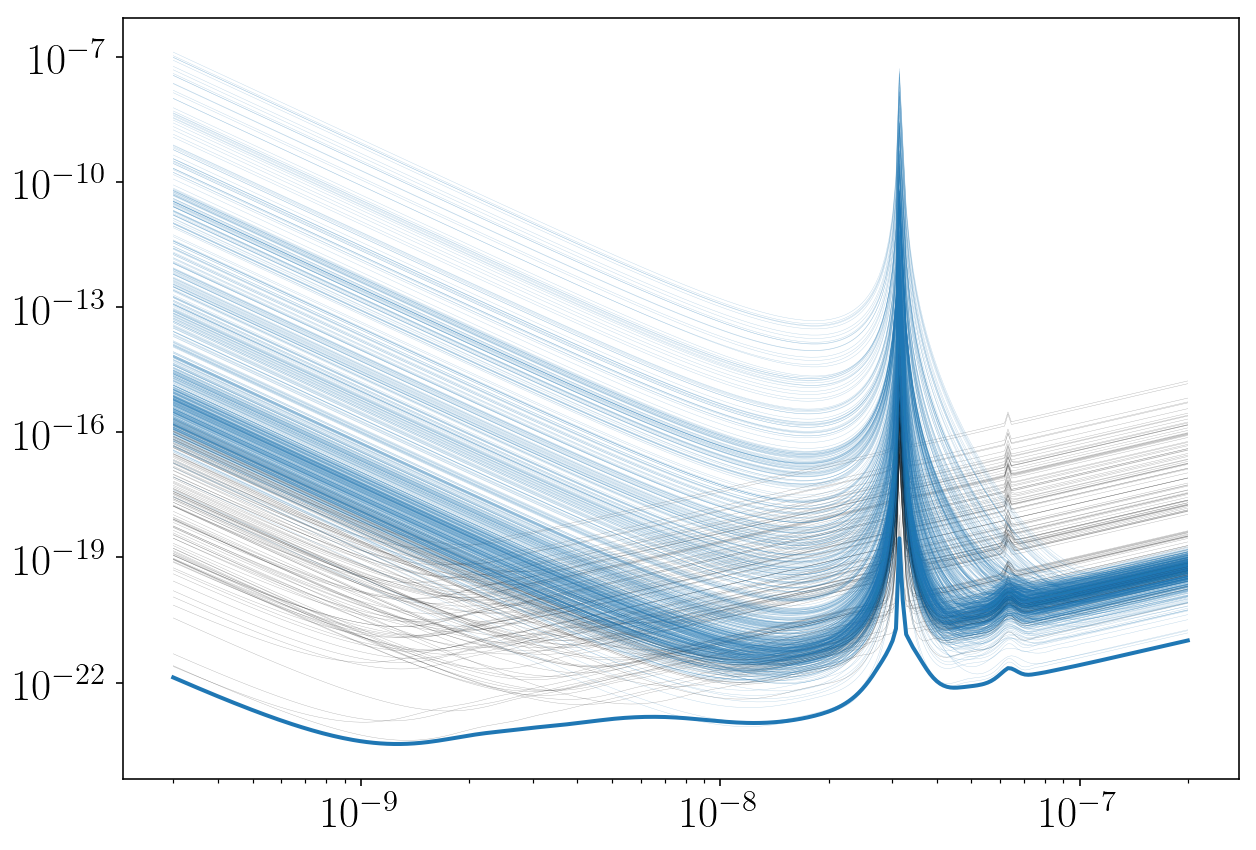

In [49]:
plt.figure(figsize=[10,7])
for sp in spec_ska1_opt:
    tspan=hsen.get_Tspan([sp])

    if tspan/(356.25*24*3600)<=4:
        color='C0'
    else:
        color='k'
    plt.loglog(sp.freqs,sp.S_I,lw=0.2,color=color,alpha=0.3)
# plt.loglog(sp.freqs,1e-15*(sp.freqs*365.25*24*3600)**(-2/3),label=r'GWB, $A_{\rm GWB}=10^{-15}$')
plt.loglog(SM_ska1_opt.freqs,SM_ska1_opt.S_eff_mean,
           label='SKA Optimistic',lw=2)

plt.show()

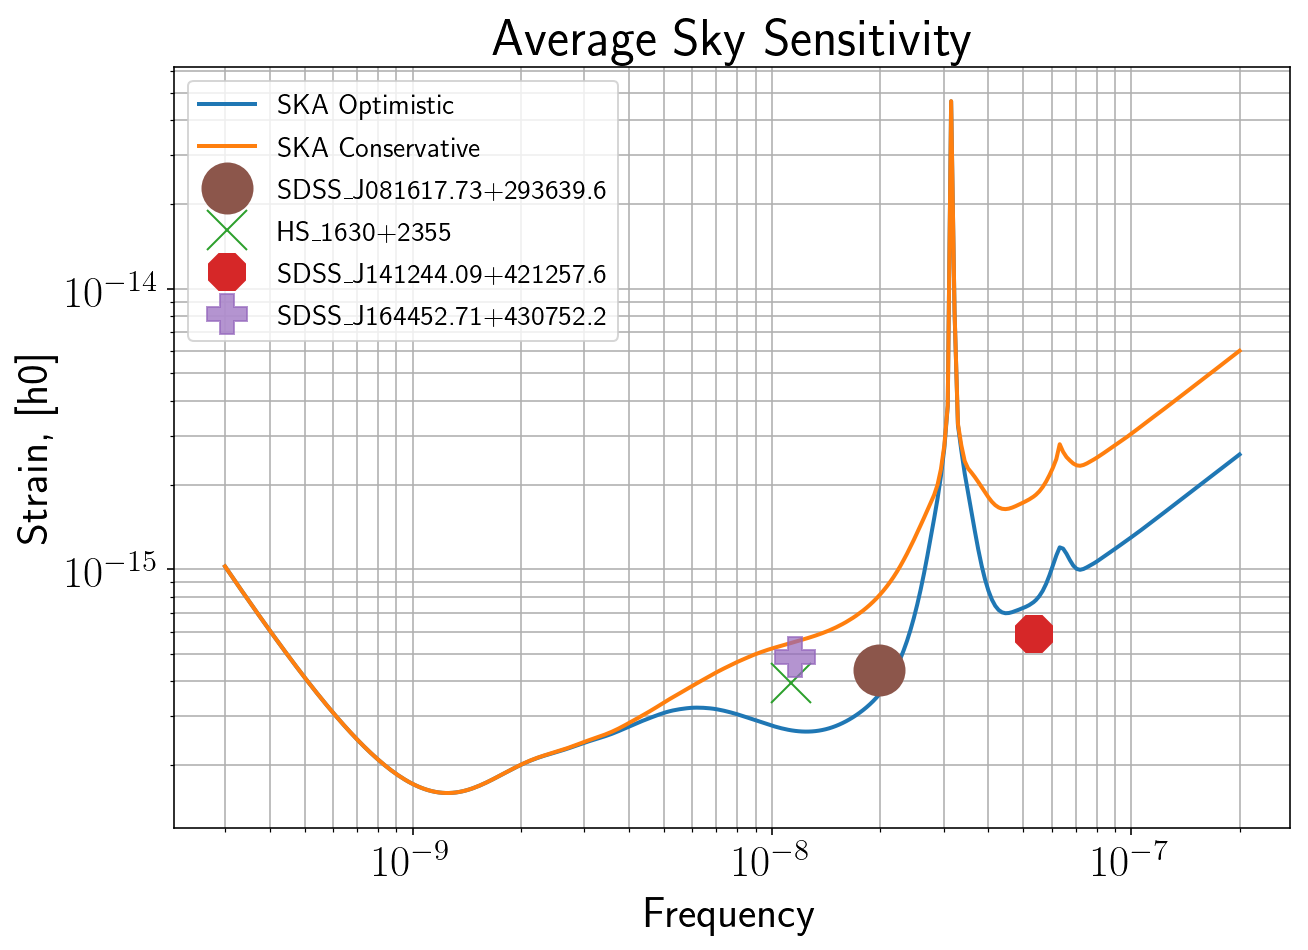

In [52]:
plt.figure(figsize=[10,7])
# plt.loglog(SM.freqs,8*np.sqrt(np.mean(SM.S_eff,axis=1)/Tspan),
#            label='NANOGrav 11yr Data w/ ECORR, EQUAD, EFAC',lw=2)
# plt.loglog(SM_simp.freqs,8*np.sqrt(np.mean(SM_simp.S_eff,axis=1)/Tspan),
#            label='NANOGrav 11yr Data w/ only TOA error',lw=2)
plt.loglog(SM_ska1_opt.freqs,sky_ave_detect(SM_ska1_opt,tspan_ska1_opt,3),
           label='SKA Optimistic',lw=2)
plt.loglog(SM_ska1_cons.freqs,sky_ave_detect(SM_ska1_cons,tspan_ska1_cons,3),
           label='SKA Conservative',lw=2)
plt.plot(1.99e-08, 4.37e-16,'.',markersize=50,color='C5',label='SDSS\_J081617.73+293639.6')
plt.plot(1.13e-08, 3.95e-16,'x',markersize=20,color='C2',label='HS\_1630+2355')
plt.plot(5.34e-08, 5.89e-16,'8',markersize=20,color='C3',label='SDSS\_J141244.09+421257.6')
plt.plot(1.16e-08, 4.88e-16,'P',markersize=20,linewidth=3,alpha=0.7,color='C4',label='SDSS\_J164452.71+430752.2')

# plt.loglog(SM_ska_opt.freqs,1e-15*(SM_ska_opt.freqs*365.25*24*3600)**(-2/3),label=r'GWB, $A_{\rm GWB}=10^{-15}$')
# plt.axvline(1.13e-8,lw=3,linestyle='--',color='k')
plt.legend(loc='upper left',fontsize=14)
plt.xlabel('Frequency')
plt.ylabel('Strain, [h0]')
plt.title('Average Sky Sensitivity')
plt.grid(which='both')
plt.show()

In [ ]:
# np.savetxt('ska1_opt_sky_ave_detect_snr3.txt',
#            np.array((SM_ska1_opt.freqs,sky_ave_detect(SM_ska1_opt,tspan_ska_opt,3))).T,
#            fmt='%.18e %.18e',header='freq[Hz] gw_strain')
# np.savetxt('ska1_cons_sky_ave_detect_snr3.txt',
#            np.array((SM_ska1_cons.freqs,sky_ave_detect(SM_ska1_cons,tspan_ska_cons,3))).T,
#            fmt='%.18e %.18e',header='freq[Hz] gw_strain')

In [53]:
print(hsky.h0_circ(2.174e8, 120, 1.13e-8).to(''))
f0=1.13e-8
hcw = hsky.h_circ(2.174e8, 120, f0, tspan_ska1_opt, SM_ska1_opt.freqs).to('').value

3.9205730966276916e-16


In [54]:
h0=hsky.h0_circ(2.174e8, 120, 1.13e-8).to('').value
SkySNR_ska1_opt = SM_ska1_opt.SNR(h0)
SkySNR_ska1_cons = SM_ska1_cons.SNR(h0)

In [55]:
SkySNR_ska1_opt[fidx,sky_idx]

4.427978522661984

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


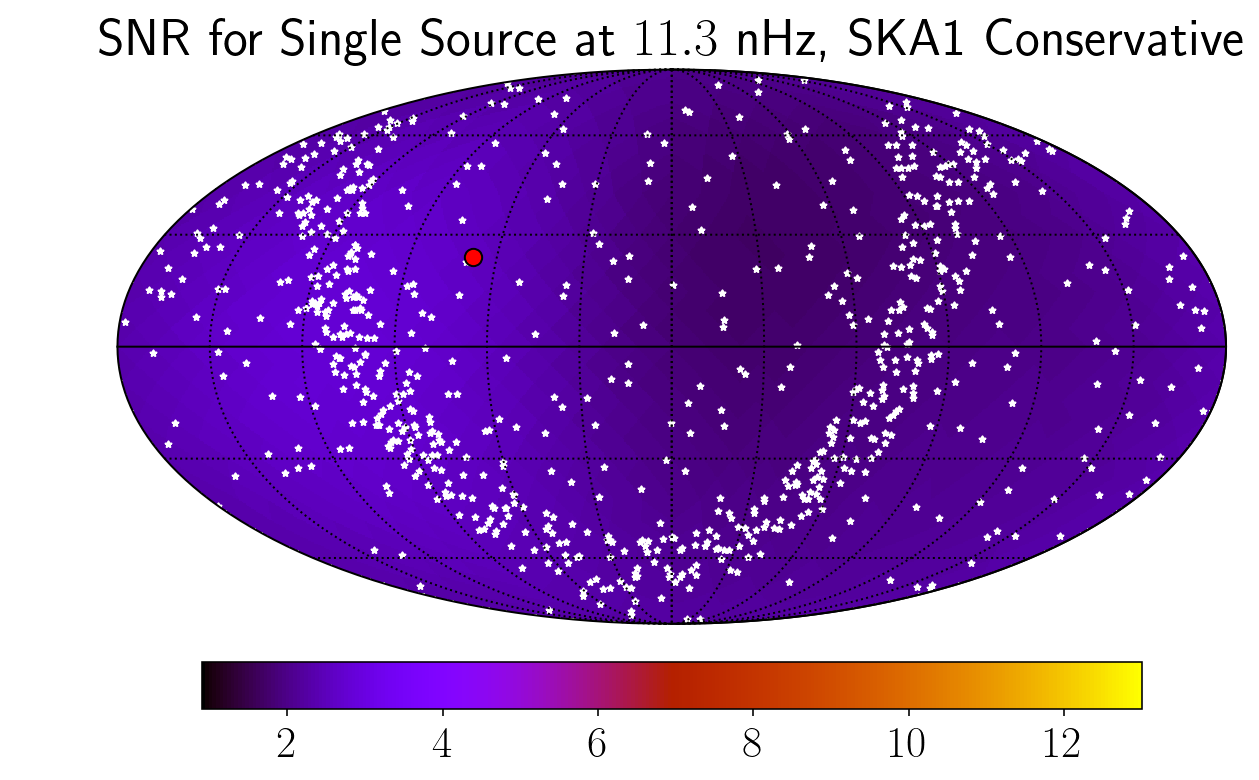

In [56]:
plt.rc('text', usetex=True)
hp.mollview(SkySNR_ska1_cons[fidx,:],rot=(180,0,0),#np.log10(1/SM.Sn[idx]),"SNR with Single Source"
            cmap='gnuplot',cbar=None,title='',min=0.9,max=13.0)
hp.visufunc.projscatter(SM_ska1_cons.thetas, SM_ska1_cons.phis,marker='*',
                        color='white', edgecolors='white',s=10)
hp.visufunc.projscatter(np.pi/2-cand3.dec.to('rad').value, cand3.ra.to('rad').value,marker='.',
                        color='red', edgecolors='black', s=300)


hp.graticule()
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cmap = fig.colorbar(image, ax=ax,orientation='horizontal',shrink=0.8,pad=0.05)

plt.rcParams.update({'font.size':22,'text.usetex':True})
ax.set_title("SNR for Single Source at $11.3$ nHz, SKA1 Conservative")
plt.show()

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


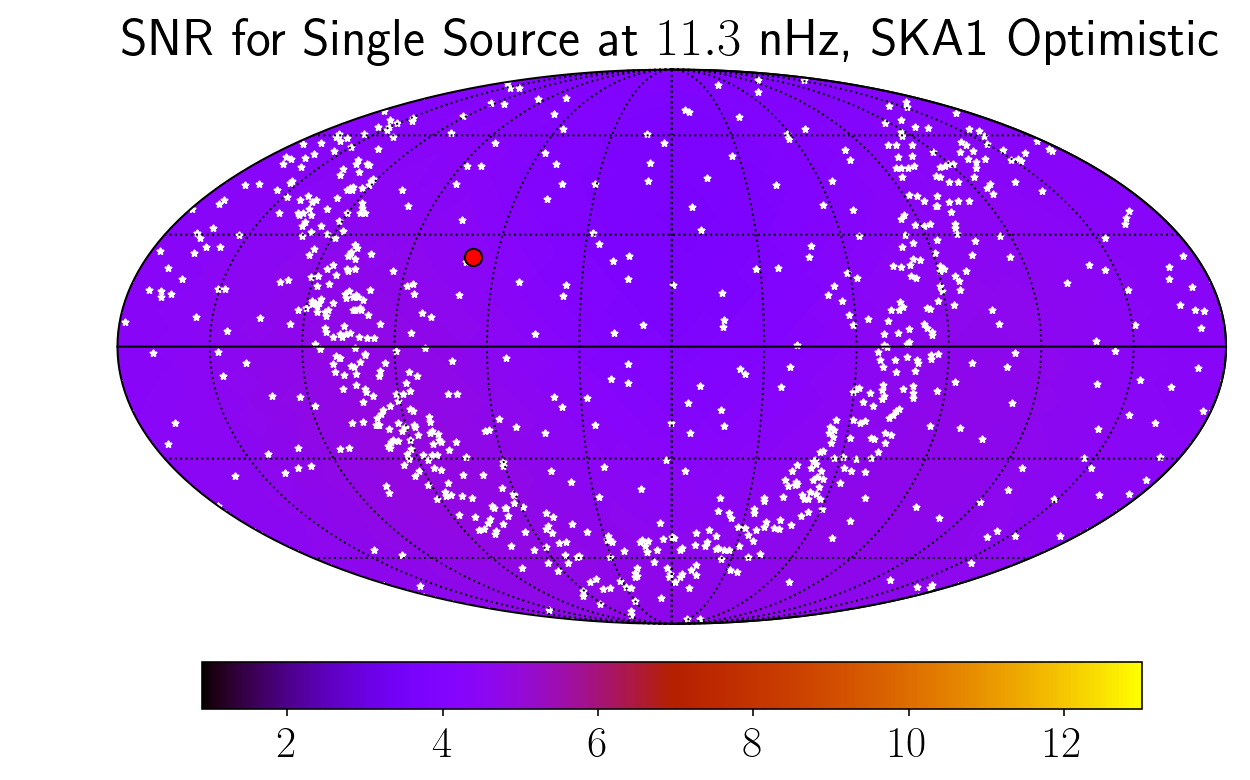

In [57]:
plt.rc('text', usetex=True)
hp.mollview(SkySNR_ska1_opt[fidx,:],rot=(180,0,0),#np.log10(1/SM.Sn[idx]),"SNR with Single Source"
            cmap='gnuplot',cbar=None,title='',min=0.9,max=13.0)
hp.visufunc.projscatter(SM_ska1_opt.thetas, SM_ska1_opt.phis,marker='*',
                        color='white', edgecolors='white',s=10)
hp.visufunc.projscatter(np.pi/2-cand3.dec.to('rad').value, cand3.ra.to('rad').value,marker='.',
                        color='red', edgecolors='black', s=300)


hp.graticule()
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cmap = fig.colorbar(image, ax=ax,orientation='horizontal',shrink=0.8,pad=0.05)

plt.rcParams.update({'font.size':22,'text.usetex':True})
ax.set_title("SNR for Single Source at $11.3$ nHz, SKA1 Optimistic")
plt.show()

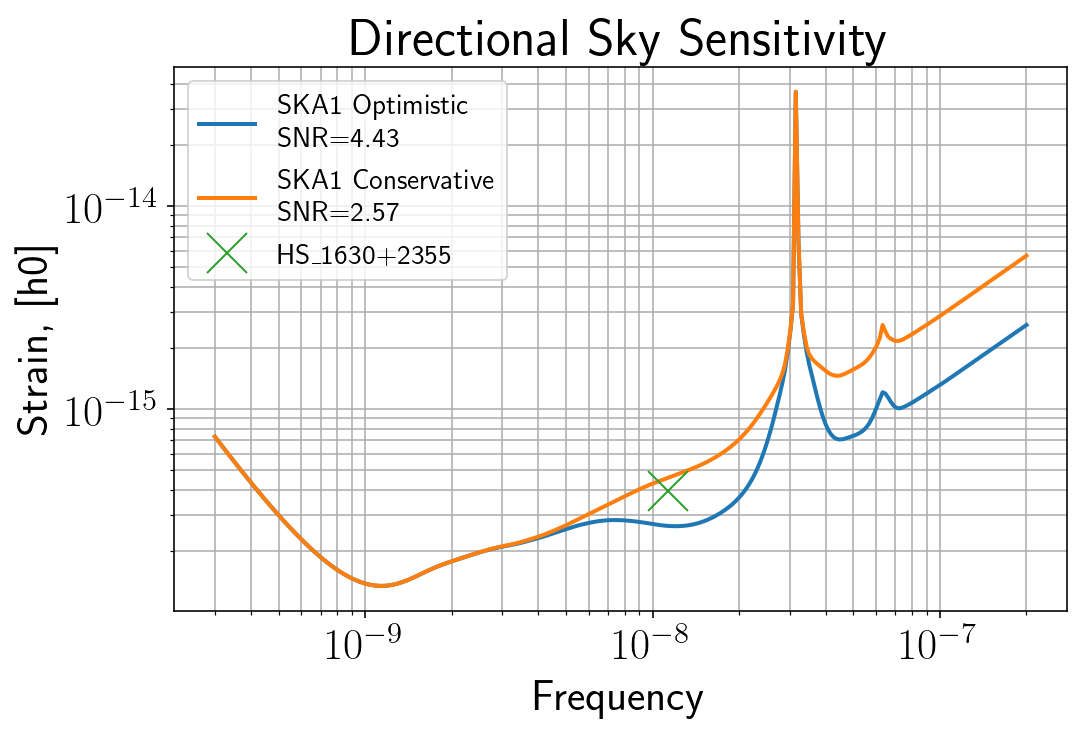

In [58]:
snr=3
plt.figure(figsize=[8,5])

plt.loglog(SM_ska1_opt.freqs,snr*np.sqrt(SM_ska1_opt.S_eff[:,sky_idx]/tspan_ska1_opt),
           label='SKA1 Optimistic\nSNR={0:1.2f}'.format(SkySNR_ska1_opt[fidx,sky_idx]),lw=2)
plt.loglog(SM_ska1_cons.freqs,snr*np.sqrt(SM_ska1_cons.S_eff[:,sky_idx]/tspan_ska1_cons),
           label='SKA1 Conservative\nSNR={0:1.2f}'.format(SkySNR_ska1_cons[fidx,sky_idx]),lw=2)
plt.plot(1.13e-08,3.95e-16,'x',markersize=20,color='C2',label='HS\_1630+2355')
plt.legend(loc='upper left',fontsize=14)
plt.xlabel('Frequency')
plt.ylabel('Strain, [h0]')
plt.title('Directional Sky Sensitivity')
plt.grid(which='both')
plt.show()

In [73]:
# np.savetxt('ska1_opt_best_sky_detect_snr3.txt',
#            np.array((SM_ska1_opt.freqs,snr*np.sqrt(SM_ska1_opt.S_eff[:,sky_idx]/tspan_ska_opt))).T,
#            fmt='%.18e %.18e',header='freq[Hz] gw_strain')
# np.savetxt('ska1_cons_best_sky_detect_snr3.txt',
#            np.array((SM_ska1_cons.freqs,snr*np.sqrt(SM_ska1_cons.S_eff[:,sky_idx]/tspan_ska_cons))).T,
#            fmt='%.18e %.18e',header='freq[Hz] gw_strain')

### SKA2

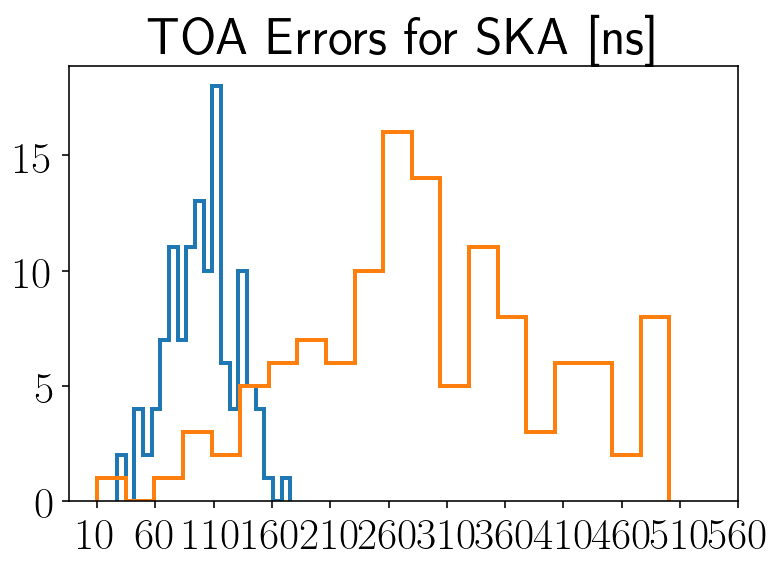

In [86]:
Np_ska2 = int(800*fraction)

ska2_errors_opt = RVSopt.rvs(Np_ska2)
ska2_errors_cons = RVScons.rvs(Np_ska2)

plt.hist(ska2_errors_opt/1e-9,bins=20,histtype='step',label='Optimistic',lw=2)
plt.hist(ska2_errors_cons/1e-9,bins=20,histtype='step',label='Pessimistic',lw=2)
plt.xticks(np.arange(10,610,50))
plt.title('TOA Errors for SKA [ns]')
plt.show()
plt.close()

new_phis_ska2 = np.random.uniform(0, 2*np.pi, size=Np_ska2)
cosTheta_ska2 = np.random.uniform(-1,1,size=Np_ska2)
new_thetas_ska2 = np.arccos(cosTheta_ska2)

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


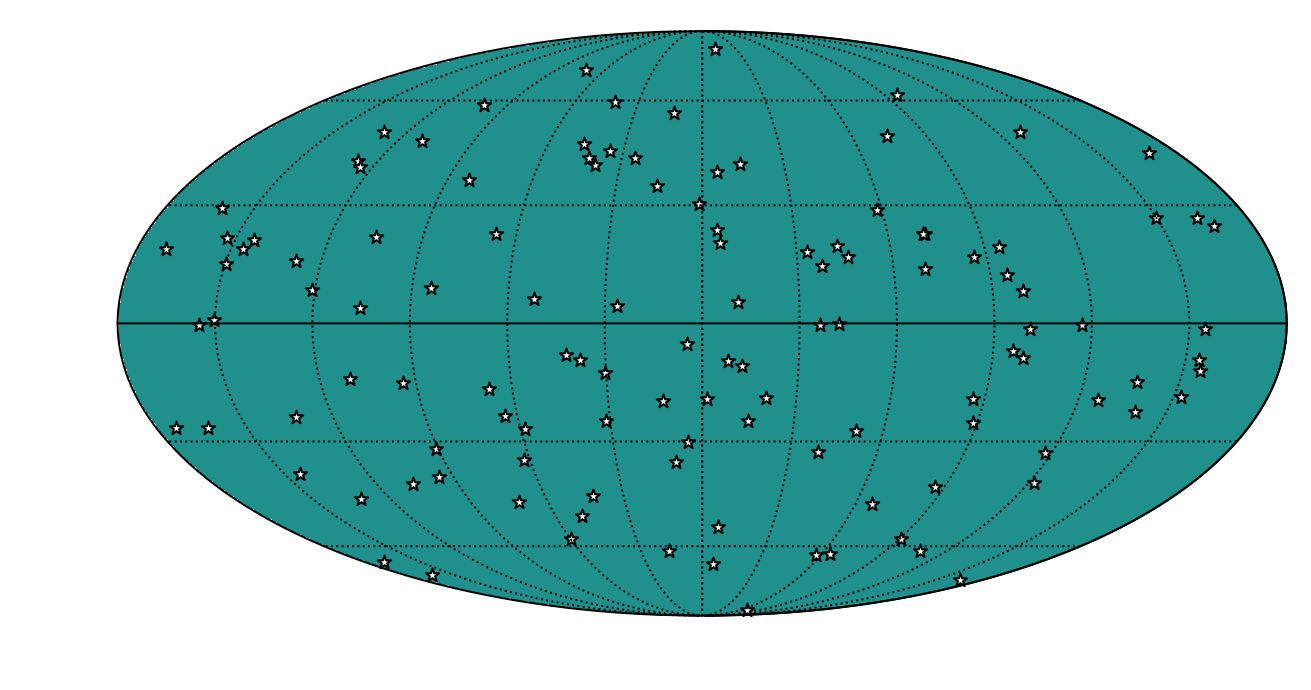

In [87]:
hp.mollview(np.ones_like(SM_ipta_plus.S_effSky[0,:]),rot=(180,0,0),#np.log10(1/SM.Sn[idx]),"SNR with Single Source"
            cmap='viridis',cbar=None,title='')
hp.visufunc.projscatter(new_thetas_ska2,new_phis_ska2,marker='*',
                        color='white',edgecolors='k',s=50)
hp.graticule()
fig = plt.gcf()
ax = plt.gca()
plt.show()
plt.close()

In [89]:
#Add 4 pulsars per year
tspans_ska2 = np.append(tspans_ska1+4,np.random.uniform(low=1,high=4,size=Np_ska2))
#Keep the average cadence of the NG11yr pulsars
cad_ska2 = np.append(cad_ska1,56*np.ones(Np_ska2))
# Add to DR2 sky locations from scipy histograms above
phis_ska2 = np.append(phis_ska1,new_phis_ska2)
thetas_ska2 = np.append(thetas_ska1,new_thetas_ska2)


sigma_ska2o = np.append(sigma_ska1o,ska2_errors_opt)
sigma_ska2c = np.append(sigma_ska1c,ska2_errors_cons)

ska2_opt = hsim.sim_pta(timespan=tspans_ska2,cad=cad_ska2,
                        sigma=sigma_ska2o,phi=phis_ska2,theta=thetas_ska2,A_rn=1e-15,alpha=-2/3.,freqs=freqs)
ska2_cons = hsim.sim_pta(timespan=tspans_ska2,cad=cad_ska2,
                         sigma=sigma_ska2c,phi=phis_ska2,theta=thetas_ska2,A_rn=1e-15,alpha=-2/3.,freqs=freqs)

NameError: name 'cad_ska1' is not defined

In [90]:
# with open('ska2_cons_has_psrs.pkl','wb') as fout:
#     pickle.dump(ska2_cons,fout)
# with open('ska2_opt_has_psrs.pkl','wb') as fout:
#     pickle.dump(ska2_opt,fout)
with open('ska2_cons_has_psrs.pkl','rb') as fin:
    ska2_cons = pickle.load(fin)
with open('ska2_opt_has_psrs.pkl','rb') as fin:
    ska2_opt = pickle.load(fin)

In [91]:
ptest = ska2_cons[0]

In [94]:
ptest.N

array([[ 3.06622759e-11,  2.88666265e-11,  2.88664785e-11, ...,
        -2.39077516e-12, -2.42647319e-12, -2.46214920e-12],
       [ 2.88666265e-11,  3.06622759e-11,  2.88666265e-11, ...,
        -2.35505517e-12, -2.39077516e-12, -2.42647319e-12],
       [ 2.88664785e-11,  2.88666265e-11,  3.06622759e-11, ...,
        -2.31931329e-12, -2.35505517e-12, -2.39077516e-12],
       ...,
       [-2.39077516e-12, -2.35505517e-12, -2.31931329e-12, ...,
         3.06622759e-11,  2.88666265e-11,  2.88664785e-11],
       [-2.42647319e-12, -2.39077516e-12, -2.35505517e-12, ...,
         2.88666265e-11,  3.06622759e-11,  2.88666265e-11],
       [-2.46214920e-12, -2.42647319e-12, -2.39077516e-12, ...,
         2.88664785e-11,  2.88666265e-11,  3.06622759e-11]])

In [93]:
for pc,po in zip(ska2_cons,ska2_opt):
    pc.N += hsen.corr_from_psd(freqs=freqs, psd=gwb, toas=pc.toas)
    po.N += hsen.corr_from_psd(freqs=freqs, psd=gwb, toas=po.toas)

In [60]:
spec_ska2_opt = []
for p in tspan_filter(ska2_opt):
    sp = hsen.Spectrum(p, freqs=freqs)
    _ = sp.NcalInv
    spec_ska2_opt.append(sp)

In [61]:
spec_ska2_cons = []
for p in tspan_filter(ska2_cons):
    sp = hsen.Spectrum(p, freqs=freqs)
    _ = sp.NcalInv
    spec_ska2_cons.append(sp)

In [62]:
SM_ska2_opt = hsky.SkySensitivity(spec_ska2_opt, theta_gw, phi_gw)#, pulsar_term=True)
SM_ska2_cons = hsky.SkySensitivity(spec_ska2_cons,theta_gw, phi_gw)
tspan_ska2_opt = SM_ska2_opt.Tspan
tspan_ska2_cons = SM_ska2_cons.Tspan

In [63]:
print(hsky.h0_circ(2.174e8, 120, 1.13e-8).to(''))
f0 = 1.13e-8
hcw = hsky.h_circ(2.174e8, 120, f0, tspan_ska2_opt, SM_ska2_opt.freqs).to('').value

3.9205730966276916e-16


In [64]:
h0=hsky.h0_circ(2.174e8, 120, 1.13e-8).to('').value
SkySNR_ska2_opt = SM_ska2_opt.SNR(h0)
SkySNR_ska2_cons = SM_ska2_cons.SNR(h0)

In [65]:
SkySNR_ska2_opt[fidx,sky_idx]

12.142733413965798

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


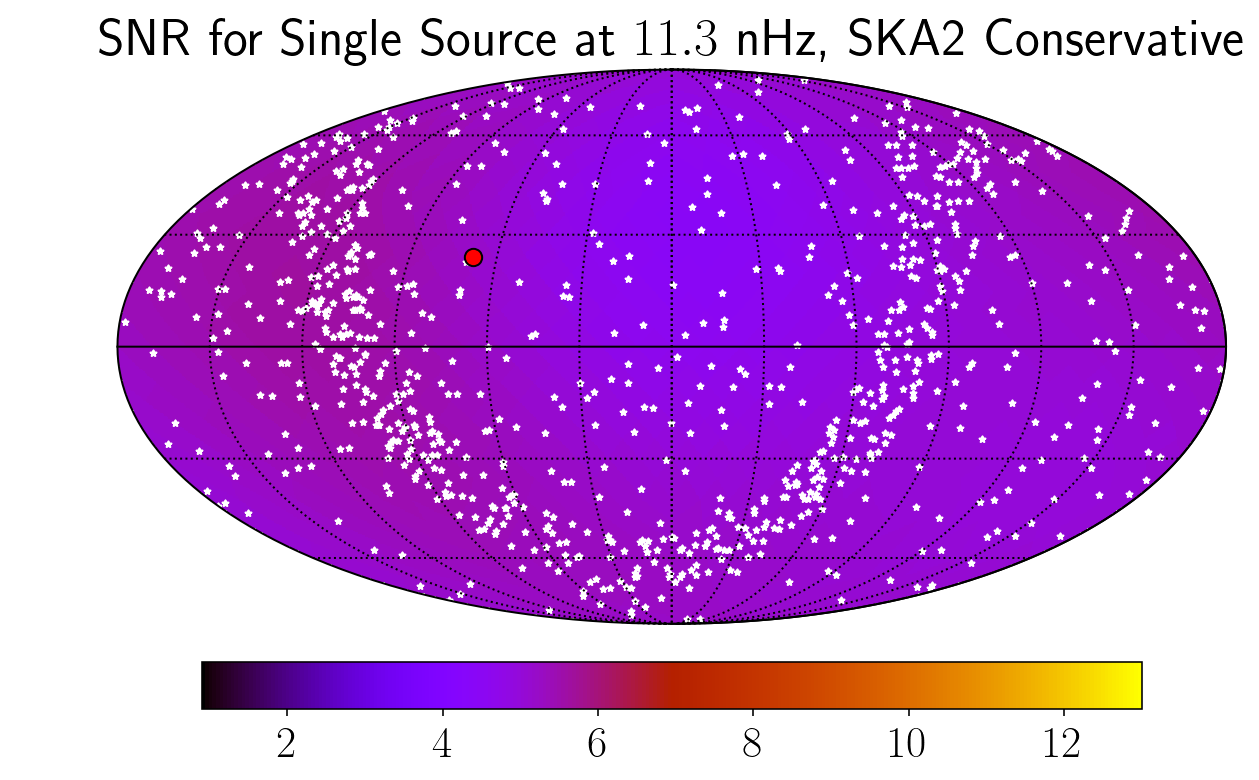

In [66]:
plt.rc('text', usetex=True)
hp.mollview(SkySNR_ska2_cons[fidx,:],rot=(180,0,0),#np.log10(1/SM.Sn[idx]),"SNR with Single Source"
            cmap='gnuplot',cbar=None,title='',min=0.9,max=13.0)
hp.visufunc.projscatter(SM_ska2_cons.thetas, SM_ska2_cons.phis,marker='*',
                        color='white', edgecolors='white',s=10)
hp.visufunc.projscatter(np.pi/2-cand3.dec.to('rad').value, cand3.ra.to('rad').value,marker='.',
                        color='red', edgecolors='black', s=300)


hp.graticule()
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cmap = fig.colorbar(image, ax=ax,orientation='horizontal',shrink=0.8,pad=0.05)

plt.rcParams.update({'font.size':22,'text.usetex':True})
ax.set_title("SNR for Single Source at $11.3$ nHz, SKA2 Conservative")
plt.show()

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


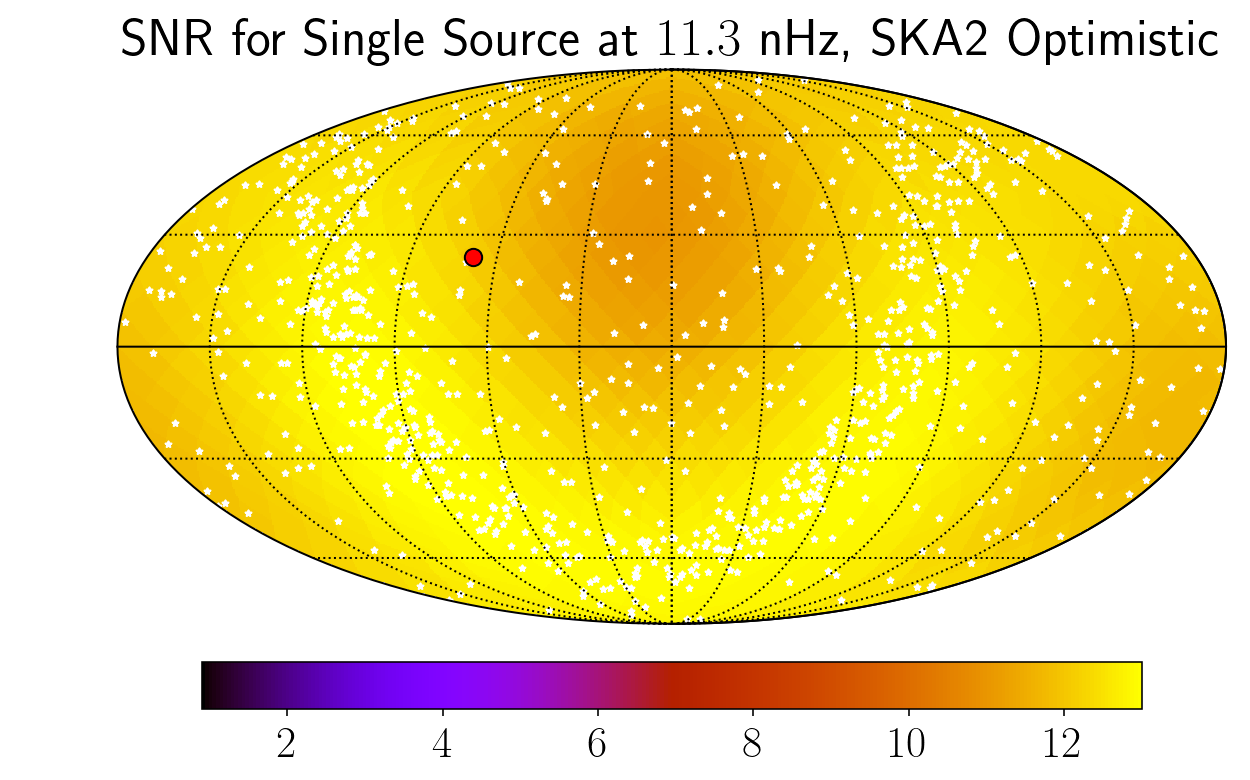

In [67]:
plt.rc('text', usetex=True)
hp.mollview(SkySNR_ska2_opt[fidx,:],rot=(180,0,0),#np.log10(1/SM.Sn[idx]),"SNR with Single Source"
            cmap='gnuplot',cbar=None,title='',min=0.9,max=13.0)
hp.visufunc.projscatter(SM_ska2_opt.thetas, SM_ska2_opt.phis,marker='*',
                        color='white', edgecolors='white',s=10)
hp.visufunc.projscatter(np.pi/2-cand3.dec.to('rad').value, cand3.ra.to('rad').value,marker='.',
                        color='red', edgecolors='black', s=300)


hp.graticule()
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cmap = fig.colorbar(image, ax=ax,orientation='horizontal',shrink=0.8,pad=0.05)

plt.rcParams.update({'font.size':22,'text.usetex':True})
ax.set_title("SNR for Single Source at $11.3$ nHz, SKA2 Optimistic")
plt.show()

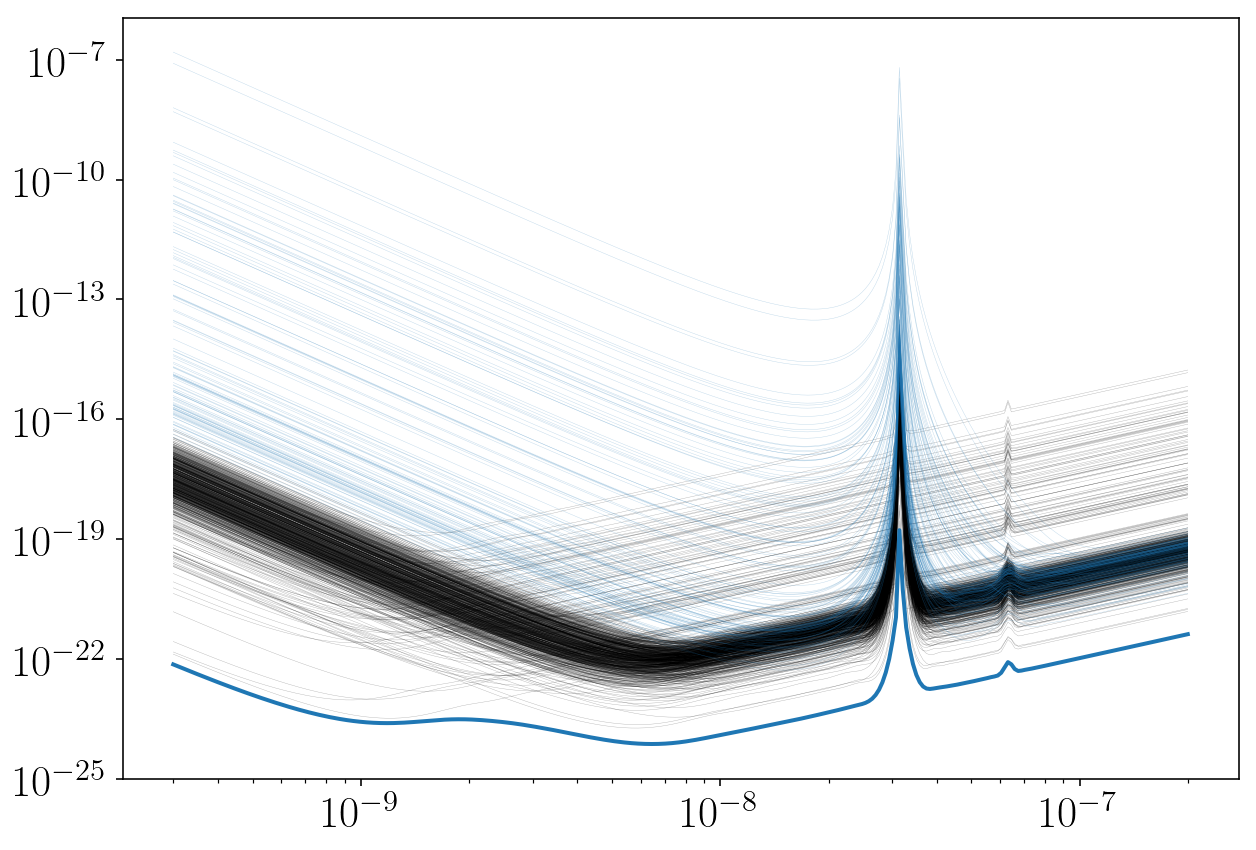

In [68]:
plt.figure(figsize=[10,7])
for sp in spec_ska2_opt:
    tspan=hsen.get_Tspan([sp])

    if tspan/(356.25*24*3600)<=4:
        color='C0'
    else:
        color='k'
    plt.loglog(sp.freqs,sp.S_I,lw=0.2,color=color,alpha=0.3)
# plt.loglog(sp.freqs,1e-15*(sp.freqs*365.25*24*3600)**(-2/3),label=r'GWB, $A_{\rm GWB}=10^{-15}$')
plt.loglog(SM_ska2_opt.freqs,SM_ska2_opt.S_eff_mean,
           label='SKA Optimistic',lw=2)

plt.show()

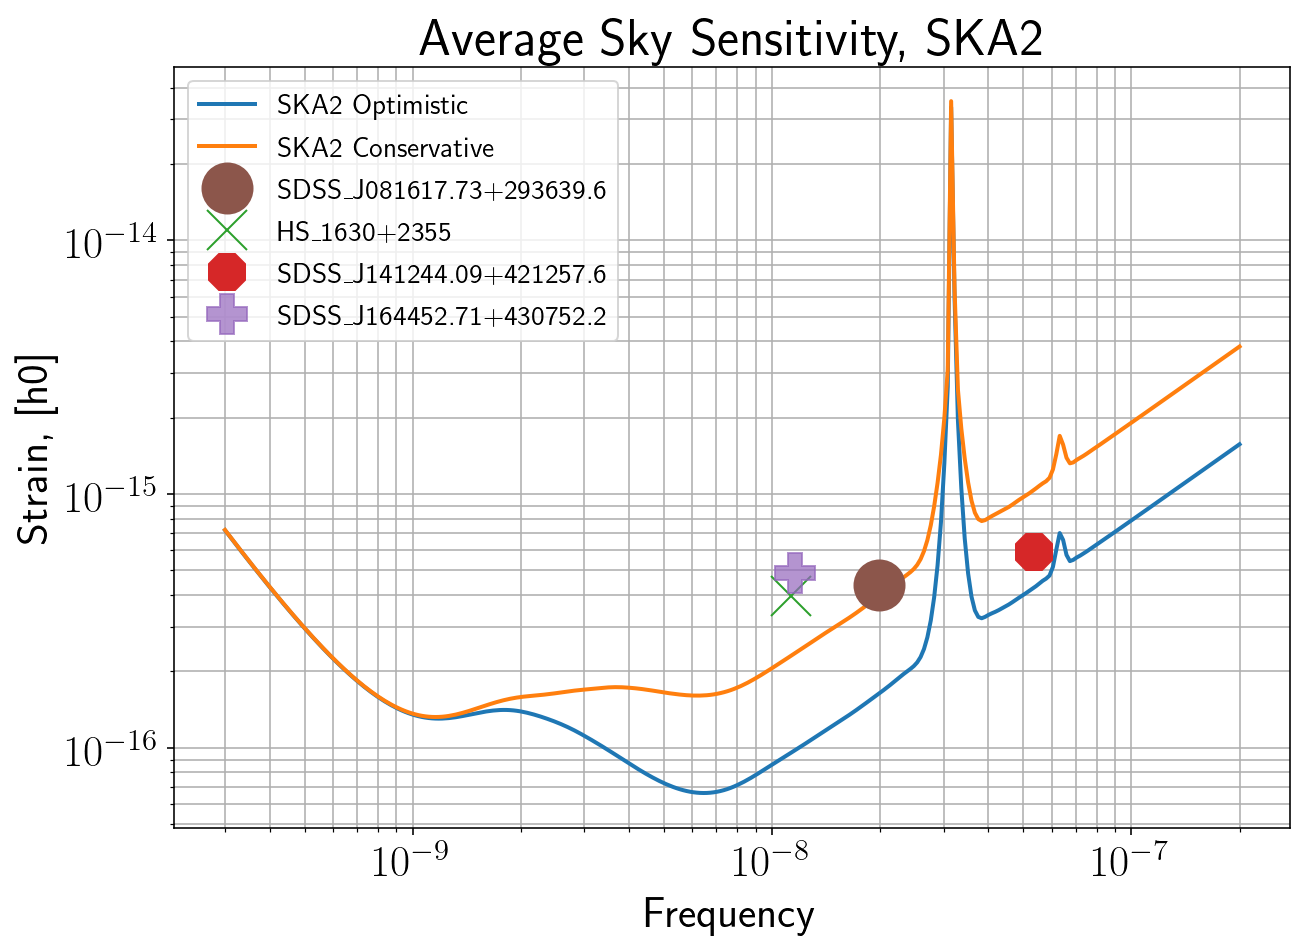

In [69]:
plt.figure(figsize=[10,7])
# plt.loglog(SM.freqs,8*np.sqrt(np.mean(SM.S_eff,axis=1)/Tspan),
#            label='NANOGrav 11yr Data w/ ECORR, EQUAD, EFAC',lw=2)
# plt.loglog(SM_simp.freqs,8*np.sqrt(np.mean(SM_simp.S_eff,axis=1)/Tspan),
#            label='NANOGrav 11yr Data w/ only TOA error',lw=2)
plt.loglog(SM_ska2_opt.freqs,sky_ave_detect(SM_ska2_opt,tspan_ska2_opt,3),
           label='SKA2 Optimistic',lw=2)
plt.loglog(SM_ska2_cons.freqs,sky_ave_detect(SM_ska2_cons,tspan_ska2_cons,3),
           label='SKA2 Conservative',lw=2)
plt.plot(1.99e-08, 4.37e-16,'.',markersize=50,color='C5',label='SDSS\_J081617.73+293639.6')
plt.plot(1.13e-08, 3.95e-16,'x',markersize=20,color='C2',label='HS\_1630+2355')
plt.plot(5.34e-08, 5.89e-16,'8',markersize=20,color='C3',label='SDSS\_J141244.09+421257.6')
plt.plot(1.16e-08, 4.88e-16,'P',markersize=20,linewidth=3,alpha=0.7,color='C4',label='SDSS\_J164452.71+430752.2')

# plt.loglog(SM_ska_opt.freqs,1e-15*(SM_ska_opt.freqs*365.25*24*3600)**(-2/3),label=r'GWB, $A_{\rm GWB}=10^{-15}$')
# plt.axvline(1.13e-8,lw=3,linestyle='--',color='k')
plt.legend(loc='upper left',fontsize=14)
plt.xlabel('Frequency')
plt.ylabel('Strain, [h0]')
plt.title('Average Sky Sensitivity, SKA2')
plt.grid(which='both')
plt.show()

In [95]:
# np.savetxt('ska2_opt_sky_ave_detect_snr3.txt',
#            np.array((SM_ska2_opt.freqs,sky_ave_detect(SM_ska2_opt,tspan_ska2_opt,3))).T,
#            fmt='%.18e %.18e',header='freq[Hz] gw_strain')
# np.savetxt('ska2_cons_sky_ave_detect_snr3.txt',
#            np.array((SM_ska2_cons.freqs,sky_ave_detect(SM_ska2_cons,tspan_ska2_cons,3))).T,
#            fmt='%.18e %.18e',header='freq[Hz] gw_strain')

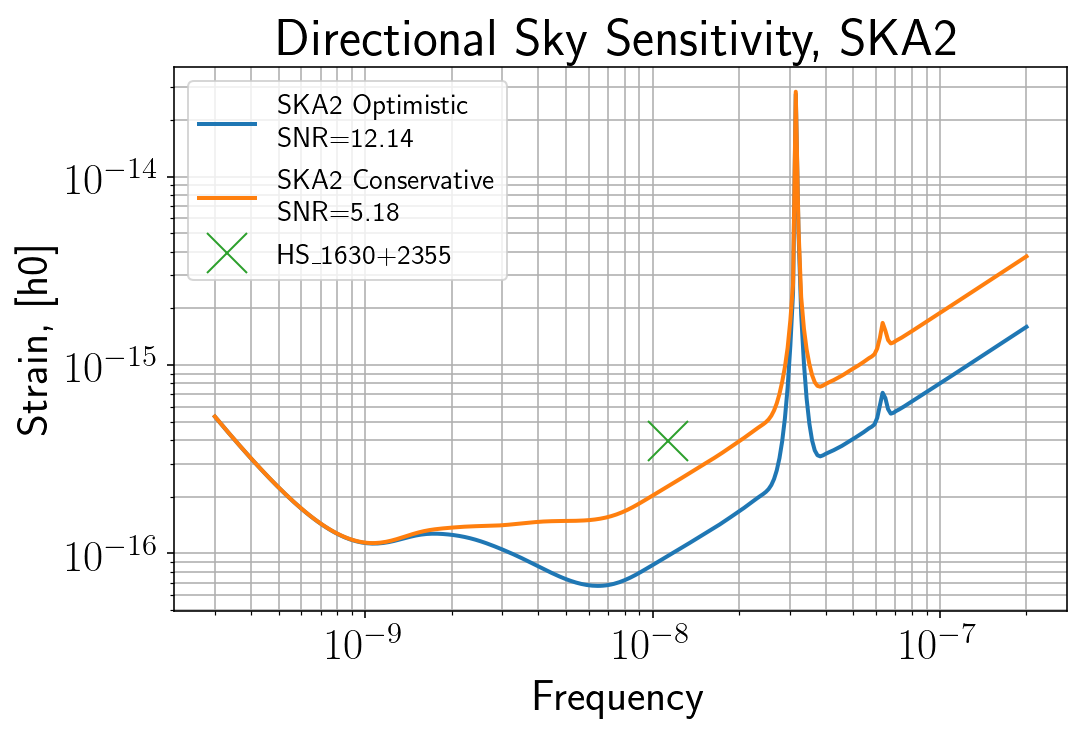

In [70]:
snr=3
plt.figure(figsize=[8,5])

plt.loglog(SM_ska2_opt.freqs,snr*np.sqrt(SM_ska2_opt.S_eff[:,sky_idx]/tspan_ska2_opt),
           label='SKA2 Optimistic\nSNR={0:1.2f}'.format(SkySNR_ska2_opt[fidx,sky_idx]),lw=2)
plt.loglog(SM_ska2_cons.freqs,snr*np.sqrt(SM_ska2_cons.S_eff[:,sky_idx]/tspan_ska2_cons),
           label='SKA2 Conservative\nSNR={0:1.2f}'.format(SkySNR_ska2_cons[fidx,sky_idx]),lw=2)
plt.plot(1.13e-08,3.95e-16,'x',markersize=20,color='C2',label='HS\_1630+2355')
plt.legend(loc='upper left',fontsize=14)
plt.xlabel('Frequency')
plt.ylabel('Strain, [h0]')
plt.title('Directional Sky Sensitivity, SKA2')
plt.grid(which='both')
plt.show()

In [98]:
# np.savetxt('ska2_opt_best_sky_detect_snr3.txt',
#            np.array((SM_ska2_opt.freqs,snr*np.sqrt(SM_ska2_opt.S_eff[:,sky_idx]/tspan_ska2_opt))).T,
#            fmt='%.18e %.18e',header='freq[Hz] gw_strain')
# np.savetxt('ska2_cons_best_sky_detect_snr3.txt',
#            np.array((SM_ska2_cons.freqs,snr*np.sqrt(SM_ska2_cons.S_eff[:,sky_idx]/tspan_ska2_cons))).T,
#            fmt='%.18e %.18e',header='freq[Hz] gw_strain')

In [71]:
fidx = np.argmin(np.abs(SM_ska2_opt.freqs-f0))
SM_ska2_opt.freqs[fidx]

1.13e-08

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


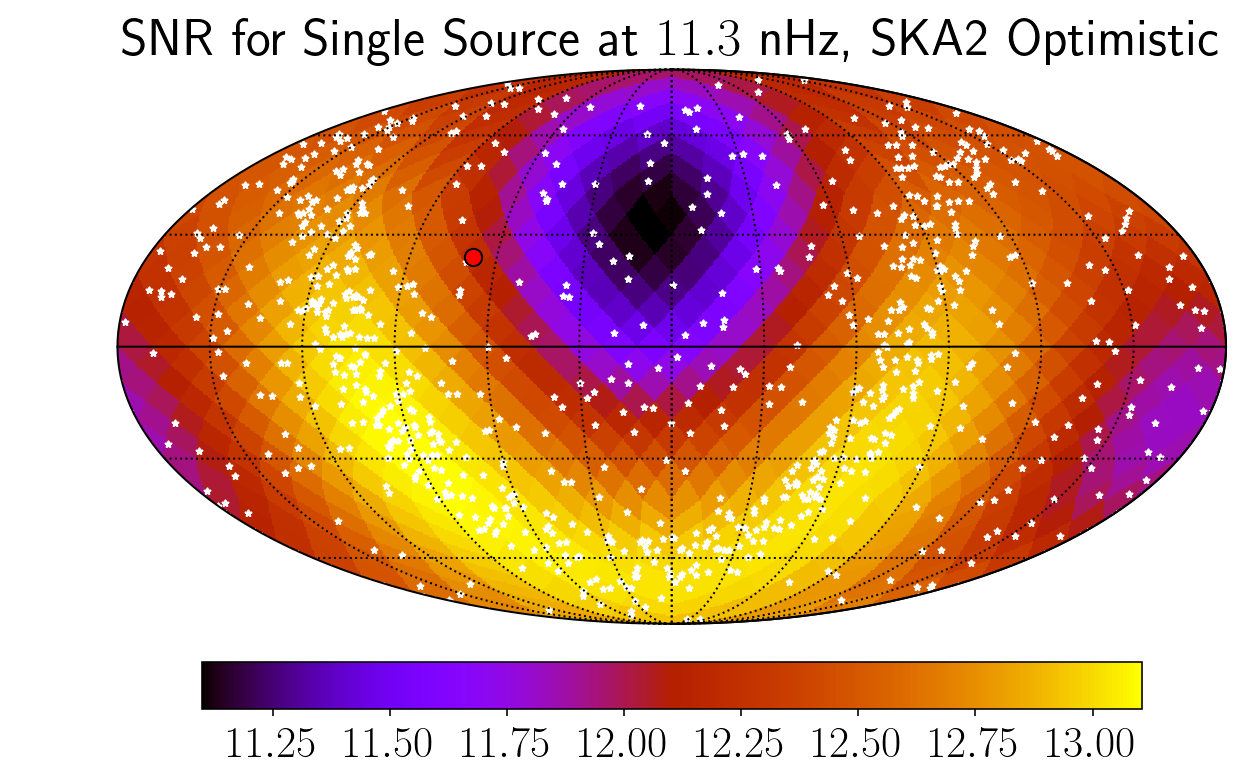

In [72]:
plt.rc('text', usetex=True)
hp.mollview(3.95e-16/sky_detect(SM_ska2_opt,tspan_ska2_opt,snr=1)[fidx,:],rot=(180,0,0),#np.log10(1/SM.Sn[idx]),"SNR with Single Source"
            cmap='gnuplot',cbar=None,title='')
hp.visufunc.projscatter(SM_ska2_opt.thetas, SM_ska2_opt.phis,marker='*',
                        color='white', edgecolors='white',s=10)
hp.visufunc.projscatter(np.pi/2-cand3.dec.to('rad').value, cand3.ra.to('rad').value,marker='.',
                        color='red', edgecolors='black', s=300)


hp.graticule()
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cmap = fig.colorbar(image, ax=ax,orientation='horizontal',shrink=0.8,pad=0.05)

plt.rcParams.update({'font.size':22,'text.usetex':True})
ax.set_title("SNR for Single Source at $11.3$ nHz, SKA2 Optimistic")
plt.show()

## Old Pulsars, New Telescopes

In [73]:
j1909_idx=list(ipta_dr2_noise['psr']).index('J1909-3744')
j1713_idx=list(ipta_dr2_noise['psr']).index('J1713+0747')
j1640_idx=list(ipta_dr2_noise['psr']).index('J1640+2224')

In [74]:
j1909_jitter = 20e-9
j1713_jitter = 40e-9
j1640_jitter = 12e-9

In [75]:
j1713_idx

23

In [76]:
psrs_ipta_plus[j1909_idx].toaerrs

array([1.89999994e-07, 1.89999994e-07, 1.89999994e-07, ...,
       1.89999994e-07, 1.89999994e-07, 1.89999994e-07])

In [78]:
ska1_opt_alt = copy.deepcopy(ska1_opt)

In [79]:
gwb = hsen.red_noise_powerlaw(A=1.4e-15,alpha=-2/3.,freqs=freqs)

In [80]:
ska1_opt_alt[j1909_idx].toaerrs[ska1_opt_alt[j1909_idx].toas/(24*3600)>ska1_opt_alt[j1909_idx].toas[-1]/(24*3600)-(365.25*5)]=20e-9
ska1_opt_alt[j1909_idx].N = (np.diag(ska1_opt_alt[j1909_idx].toaerrs**2)
                             + hsen.corr_from_psd(freqs=freqs, psd=gwb, toas=ska1_opt_alt[j1909_idx].toas))

In [81]:
ska1_opt_alt[j1713_idx].toaerrs[ska1_opt_alt[j1713_idx].toas/(24*3600)>ska1_opt_alt[j1713_idx].toas[-1]/(24*3600)-(365.25*5)]=40e-9
ska1_opt_alt[j1713_idx].N = (np.diag(ska1_opt_alt[j1713_idx].toaerrs**2)
                             + hsen.corr_from_psd(freqs=freqs, psd=gwb, toas=ska1_opt_alt[j1713_idx].toas))

In [82]:
ska1_opt_alt[j1640_idx].toaerrs[ska1_opt_alt[j1640_idx].toas/(24*3600)>ska1_opt_alt[j1640_idx].toas[-1]/(24*3600)-(365.25*5)]=12e-9
ska1_opt_alt[j1640_idx].N = (np.diag(ska1_opt_alt[j1640_idx].toaerrs**2)
                             + hsen.corr_from_psd(freqs=freqs, psd=gwb, toas=ska1_opt_alt[j1640_idx].toas))

In [83]:
# with open('ska1_opt_jitter_has_psrswGWB_ng11yr.pkl','wb') as fout:
#     pickle.dump(ska1_opt_alt,fout)
# with open('ska2_opt_jitter_has_psrs.pkl','wb') as fout:
#     pickle.dump(ska2_opt_alt,fout)
# with open('ska1_opt_jitter_has_psrs.pkl','rb') as fin:
#     ska1_opt_alt = pickle.load(fin)
# with open('ska2_opt_jitter_has_psrs.pkl','rb') as fin:
#     ska2_opt_alt = pickle.load(fin)

In [96]:
# with open('ska2_opt_jitter_has_psrswGWB_ng11yr.pkl','wb') as fout:
#     pickle.dump(ska2_opt_alt2,fout)

In [77]:
spec_ska1_opt_alt = []
for p in tspan_filter(ska1_opt_alt):
    sp = hsen.Spectrum(p, freqs=freqs)
    _ = sp.NcalInv
    spec_ska1_opt_alt.append(sp)

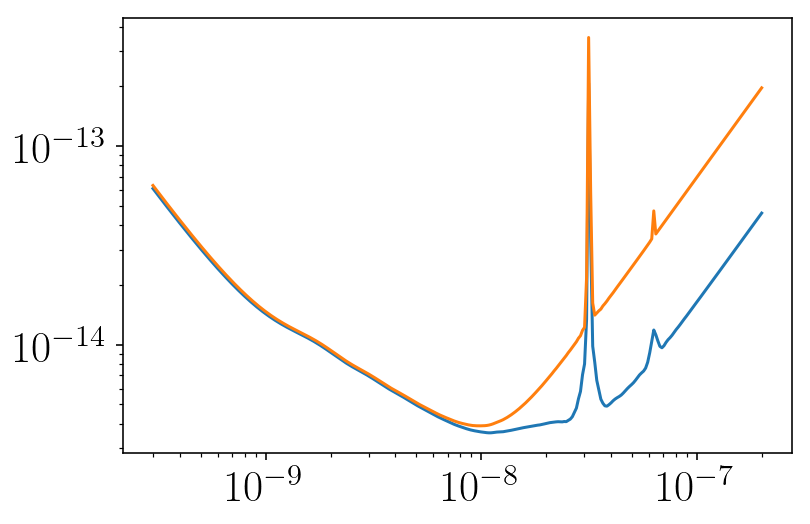

In [80]:
plt.loglog(freqs,spec_ska1_opt_alt[j1909_idx].h_c)
plt.loglog(freqs,hsen.Spectrum(ska1_opt[j1909_idx], freqs=freqs).h_c)
plt.show()

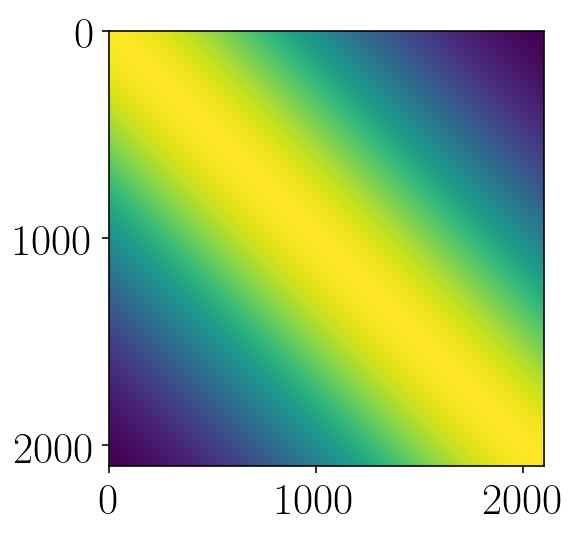

In [81]:
plt.imshow(ska1_opt_alt[j1713_idx].N)
plt.show()

In [116]:
ska2_opt_alt = copy.deepcopy(ska2_opt)

In [117]:
ska2_opt_alt[j1909_idx].toaerrs[ska2_opt_alt[j1909_idx].toas/(24*3600)>ska2_opt_alt[j1909_idx].toas[-1]/(24*3600)-(365.25*5)]=20e-9
ska2_opt_alt[j1909_idx].N = np.diag(ska2_opt_alt[j1909_idx].toaerrs**2)

In [118]:
ska2_opt_alt[j1713_idx].toaerrs[ska2_opt_alt[j1713_idx].toas/(24*3600)>ska2_opt_alt[j1713_idx].toas[-1]/(24*3600)-(365.25*5)]=40e-9
ska2_opt_alt[j1713_idx].N = np.diag(ska2_opt_alt[j1713_idx].toaerrs**2)

In [119]:
ska2_opt_alt[j1640_idx].toaerrs[ska2_opt_alt[j1640_idx].toas/(24*3600)>ska2_opt_alt[j1640_idx].toas[-1]/(24*3600)-(365.25*5)]=12e-9
ska2_opt_alt[j1640_idx].N = np.diag(ska2_opt_alt[j1640_idx].toaerrs**2)

In [95]:
ska2_opt_alt2 = copy.deepcopy(ska2_opt)
ska2_opt_alt2[j1909_idx].toaerrs[ska2_opt_alt2[j1909_idx].toas/(24*3600)>ska2_opt_alt2[j1909_idx].toas[-1]/(24*3600)-(365.25*5)]=20e-9
ska2_opt_alt2[j1909_idx].N = (np.diag(ska2_opt_alt2[j1909_idx].toaerrs**2)
                              + hsen.corr_from_psd(freqs=freqs, psd=gwb, toas=ska2_opt_alt2[j1909_idx].toas))
ska2_opt_alt2[j1713_idx].toaerrs[ska2_opt_alt2[j1713_idx].toas/(24*3600)>ska2_opt_alt2[j1713_idx].toas[-1]/(24*3600)-(365.25*5)]=40e-9
ska2_opt_alt2[j1713_idx].N = (np.diag(ska2_opt_alt2[j1713_idx].toaerrs**2)
                              + hsen.corr_from_psd(freqs=freqs, psd=gwb, toas=ska2_opt_alt2[j1713_idx].toas))
ska2_opt_alt2[j1640_idx].toaerrs[ska2_opt_alt2[j1640_idx].toas/(24*3600)>ska2_opt_alt2[j1640_idx].toas[-1]/(24*3600)-(365.25*5)]=12e-9
ska2_opt_alt2[j1640_idx].N = (np.diag(ska2_opt_alt2[j1640_idx].toaerrs**2)
                              + hsen.corr_from_psd(freqs=freqs, psd=gwb, toas=ska2_opt_alt2[j1640_idx].toas))

In [120]:
spec_ska2_opt_alt = []
for p in tspan_filter(ska2_opt_alt):
    sp = hsen.Spectrum(p, freqs=freqs)
    _ = sp.NcalInv
    spec_ska2_opt_alt.append(sp)

In [102]:
SM_ska1_opt_alt = hsky.SkySensitivity(spec_ska1_opt_alt, theta_gw, phi_gw)#, pulsar_term=True)
tspan_ska1_opt_alt = hsen.get_Tspan(ska1_opt_alt)

In [121]:
SM_ska2_opt_alt = hsky.SkySensitivity(spec_ska2_opt_alt, theta_gw, phi_gw)#, pulsar_term=True)
tspan_ska2_opt_alt = hsen.get_Tspan(ska2_opt_alt)

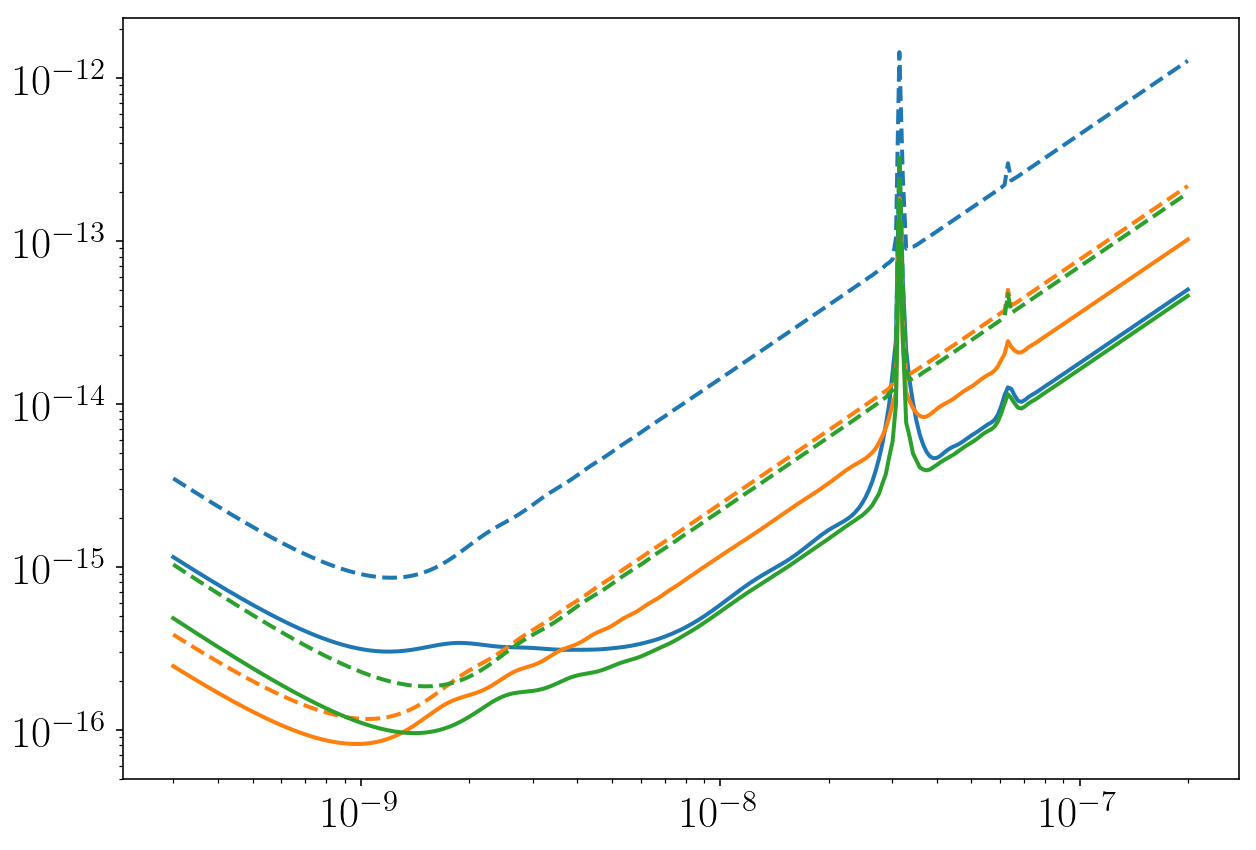

In [103]:
plt.figure(figsize=[10,7])
for idx,col in zip([j1640_idx,j1713_idx,j1909_idx],['C0','C1','C2']):
    sp = spec_ska1_opt_alt[idx]
    sp_old = spec_ska1_opt[idx]
    plt.loglog(sp.freqs,sp.h_c,lw=2,color=col)
    plt.loglog(sp_old.freqs,sp_old.h_c,linestyle='--',lw=2,color=col)
    
# plt.loglog(sp.freqs,1e-15*(sp.freqs*365.25*24*3600)**(-2/3),label=r'GWB, $A_{\rm GWB}=10^{-15}$')

plt.show()

In [129]:
h0=hsky.h0_circ(2.174e8, 120, 1.13e-8).to('').value
SkySNR_ska1_opt_alt = SM_ska1_opt_alt.SNR(h0)
SkySNR_ska2_opt_alt = SM_ska2_opt_alt.SNR(h0)

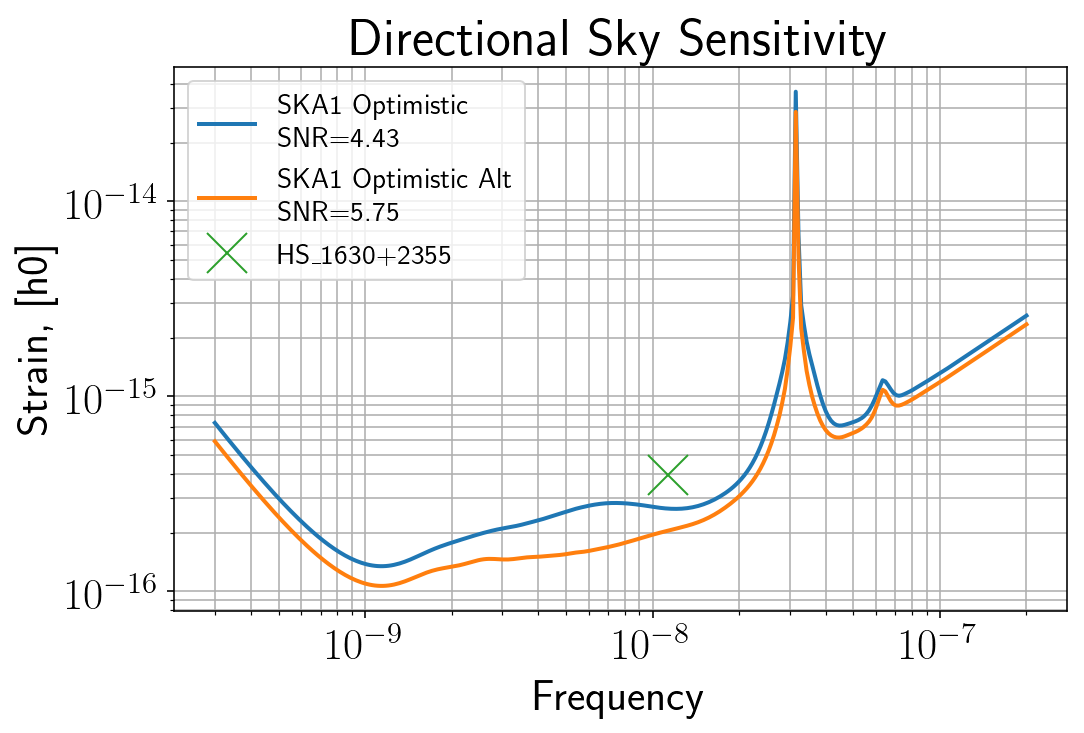

In [105]:
snr=3
plt.figure(figsize=[8,5])

plt.loglog(SM_ska1_opt.freqs,snr*np.sqrt(SM_ska1_opt.S_eff[:,sky_idx]/tspan_ska_opt),
           label='SKA1 Optimistic\nSNR={0:1.2f}'.format(SkySNR_ska1_opt[fidx,sky_idx]),lw=2)
plt.loglog(SM_ska1_opt_alt.freqs,snr*np.sqrt(SM_ska1_opt_alt.S_eff[:,sky_idx]/tspan_ska_cons),
           label='SKA1 Optimistic Alt\nSNR={0:1.2f}'.format(SkySNR_ska1_opt_alt[fidx,sky_idx]),lw=2)
plt.plot(1.13e-08,3.95e-16,'x',markersize=20,color='C2',label='HS\_1630+2355')
plt.legend(loc='upper left',fontsize=14)
plt.xlabel('Frequency')
plt.ylabel('Strain, [h0]')
plt.title('Directional Sky Sensitivity')
plt.grid(which='both')
plt.show()

In [106]:
SkySNR_ska1_opt_alt[fidx,sky_idx]/SkySNR_ska1_opt[fidx,sky_idx]

1.2976645921397